<a href="https://colab.research.google.com/github/stranger9977/market_implied_fantasy_football/blob/main/playerpropprojections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import re
import nfl_data_py as nfl
from IPython.display import display, HTML
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("API_KEY")

In [17]:
api_key


'554d1e6028cada8b9a8e0ec139fde16a'

In [ ]:


# Get the current time in ISO8601 format
current_time_iso = datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")

# Your API key
api_key = api_key

# Regions and Markets
regions = ["us",'us2']
# check this out for avaialble markets https://the-odds-api.com/sports-odds-data/betting-markets.html
markets = [    'player_anytime_td',
    'player_pass_completions',
    'player_pass_interceptions',
    'player_pass_tds',
    'player_pass_yds',
    'player_reception_yds',
    'player_receptions',
    'player_rush_yds']

format = "american"

# Convert list to comma-separated string
regions_str = ",".join(regions)
markets_str = ",".join(markets)

# Date range for filtering events (for the current time)
commence_time_from = current_time_iso
commence_time_to = current_time_iso

# Step 1: Fetch event IDs
url_events = f"https://api.the-odds-api.com/v4/sports/americanfootball_nfl/events/?apiKey={api_key}&regions={regions_str}&commenceTimeFrom={commence_time_from}&commenceTimeTo={commence_time_to}&oddsFormat={format}"
response_events = requests.get(url_events)
events_data = response_events.json()

# Extract event IDs
event_ids = [event['id'] for event in events_data]

# Initialize an empty list to store the fetched data
fetched_data = []

# Fetch odds for each event ID
for event_id in event_ids:
    url_odds = f"https://api.the-odds-api.com/v4/sports/americanfootball_nfl/events/{event_id}/odds/?apiKey={api_key}&regions={regions_str}&markets={markets_str}&oddsFormat={format}"
    response_odds = requests.get(url_odds)
    odds_data = response_odds.json()

    # Store the fetched data along with the event_id
    fetched_data.append({'event_id': event_id, 'odds_data': odds_data})


In [3]:
print(fetched_data[0:1])

[{'event_id': '934acd8d5f569c955f4a02aa42284fa4', 'odds_data': {'id': '934acd8d5f569c955f4a02aa42284fa4', 'sport_key': 'americanfootball_nfl', 'sport_title': 'NFL', 'commence_time': '2023-09-29T00:15:00Z', 'home_team': 'Green Bay Packers', 'away_team': 'Detroit Lions', 'bookmakers': [{'key': 'fanduel', 'title': 'FanDuel', 'markets': [{'key': 'player_anytime_td', 'last_update': '2023-09-27T16:33:03Z', 'outcomes': [{'name': 'Yes', 'description': 'AJ Dillon', 'price': 110}, {'name': 'Yes', 'description': 'Jahmyr Gibbs', 'price': 125}, {'name': 'Yes', 'description': 'Aaron Jones', 'price': 125}, {'name': 'Yes', 'description': 'Amon-Ra St. Brown', 'price': 140}, {'name': 'Yes', 'description': 'David Montgomery', 'price': 145}, {'name': 'Yes', 'description': 'Christian Watson', 'price': 230}, {'name': 'Yes', 'description': 'Romeo Doubs', 'price': 230}, {'name': 'Yes', 'description': 'Sam LaPorta', 'price': 250}, {'name': 'Yes', 'description': 'Luke Musgrave', 'price': 290}, {'name': 'Yes', '

In [4]:
import pandas as pd

# Initialize an empty DataFrame
odds_df = pd.DataFrame()

# Iterate through the fetched data
for data in fetched_data:
    event_id = data['event_id']
    odds_data = data['odds_data']

    # Convert JSON to DataFrame
    temp_df = pd.json_normalize(odds_data, sep='_')

    # Add event_id as a level of multi-index
    temp_df['game_id'] = event_id

    # Extract bookmakers data into separate DataFrame and merge
    for bookmaker in odds_data['bookmakers']:
      if isinstance(bookmaker, dict):
          for market in bookmaker['markets']:
              bookmaker_df = pd.json_normalize(market['outcomes'], sep='_')
              bookmaker_df['bookmaker'] = bookmaker['key']
              bookmaker_df['last_update'] = market['last_update']
              bookmaker_df['market'] = market['key']

              # Check if 'point' exists and include it
              points = [outcome.get('point', None) for outcome in market['outcomes']]
              bookmaker_df['point'] = points

              # Concatenate with other relevant columns
              bookmaker_df = pd.concat([temp_df[['game_id', 'commence_time', 'home_team', 'away_team']], bookmaker_df], axis=1)

              # Append to the final DataFrame
              odds_df = pd.concat([odds_df, bookmaker_df])

# Convert 'price' and 'point' columns to numeric
odds_df['price'] = pd.to_numeric(odds_df['price'], errors='coerce')
odds_df['point'] = pd.to_numeric(odds_df['point'], errors='coerce')

# Forward fill the NaN values for these columns
odds_df[['game_id', 'commence_time', 'home_team', 'away_team']] = odds_df[['game_id', 'commence_time', 'home_team', 'away_team']].fillna(method='ffill')

# Display DataFrame info
odds_df.info(verbose=True)




<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 0 to 1
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        1681 non-null   object 
 1   commence_time  1681 non-null   object 
 2   home_team      1681 non-null   object 
 3   away_team      1681 non-null   object 
 4   name           1681 non-null   object 
 5   description    1681 non-null   object 
 6   price          1681 non-null   int64  
 7   bookmaker      1681 non-null   object 
 8   last_update    1681 non-null   object 
 9   market         1681 non-null   object 
 10  point          722 non-null    float64
dtypes: float64(1), int64(1), object(9)
memory usage: 157.6+ KB


In [5]:
odds_df

,game_id,commence_time,home_team,away_team,name,description,price,bookmaker,last_update,market,point
0,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,AJ Dillon,110,fanduel,2023-09-27T16:33:03Z,player_anytime_td,NaN
1,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Jahmyr Gibbs,125,fanduel,2023-09-27T16:33:03Z,player_anytime_td,NaN
2,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Aaron Jones,125,fanduel,2023-09-27T16:33:03Z,player_anytime_td,NaN
3,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Amon-Ra St. Brown,140,fanduel,2023-09-27T16:33:03Z,player_anytime_td,NaN
4,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,David Montgomery,145,fanduel,2023-09-27T16:33:03Z,player_anytime_td,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Over,Dak Prescott,-120,fliff,2023-09-27T16:29:03Z,player_pass_yds,233.5
2,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Under,Mac Jones,-120,fliff,2023-09-27T16:29:03Z,player_pass_yds,215.5
3,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Over,Mac Jones,-120,fliff,2023-09-27T16:29:03Z,player_pass_yds,215.5
0,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Under,CeeDee Lamb,-120,fliff,2023-09-27T16:29:03Z,player_reception_yds,69.5


In [ ]:
# TO DO ..
# Get Historical Player Prop odds?
# import requests
# from datetime import datetime

# # Specify the date for which you want to fetch data (September 8th, 2022)
# specified_date = "2023-09-08T11:00:00Z"

# # Your API key
# api_key = "554d1e6028cada8b9a8e0ec139fde16a"

# # Regions and Markets
# regions = ["us"]
# markets = ['player_anytime_td']  # One market for this example

# # Convert list to comma-separated string
# regions_str = ",".join(regions)
# markets_str = ",".join(markets)

# # Step 1: Fetch event IDs
# url_events = f"https://api.the-odds-api.com/v4/sports/americanfootball_nfl/odds-history/?apiKey={api_key}&regions={regions_str}&date={specified_date}"
# response_events = requests.get(url_events)
# events_data = response_events.json()

# # Check if 'data' key exists in the dictionary
# if 'data' in events_data:
#     # Extract event IDs
#     event_ids = [event['id'] for event in events_data['data']]
# else:
#     print("No 'data' key found in the response.")
#     event_ids = []

# # Step 2: Fetch odds for each event ID using the new endpoint
# for event_id in event_ids:
#     url_odds = f"https://api.the-odds-api.com/v4/sports/americanfootball_nfl/events/{event_id}/odds/?apiKey={api_key}&regions={regions_str}&markets={markets_str}&dateFormat=iso&oddsFormat=decimal"
#     response_odds = requests.get(url_odds)
#     odds_data = response_odds.json()
#     print(f"Odds for event ID {event_id}: {odds_data}")


In [6]:

# Assuming df is your DataFrame
# Define the list of markets you want to keep
markets_to_keep = [
    'player_anytime_td',
    'player_pass_completions',
    'player_pass_interceptions',
    'player_pass_tds',
    'player_pass_yds',
    'player_reception_yds',
    'player_receptions',
    'player_rush_yds'
]

# Filter the DataFrame to only include rows with the specified markets
odds_df = odds_df[odds_df['market'].isin(markets_to_keep)]



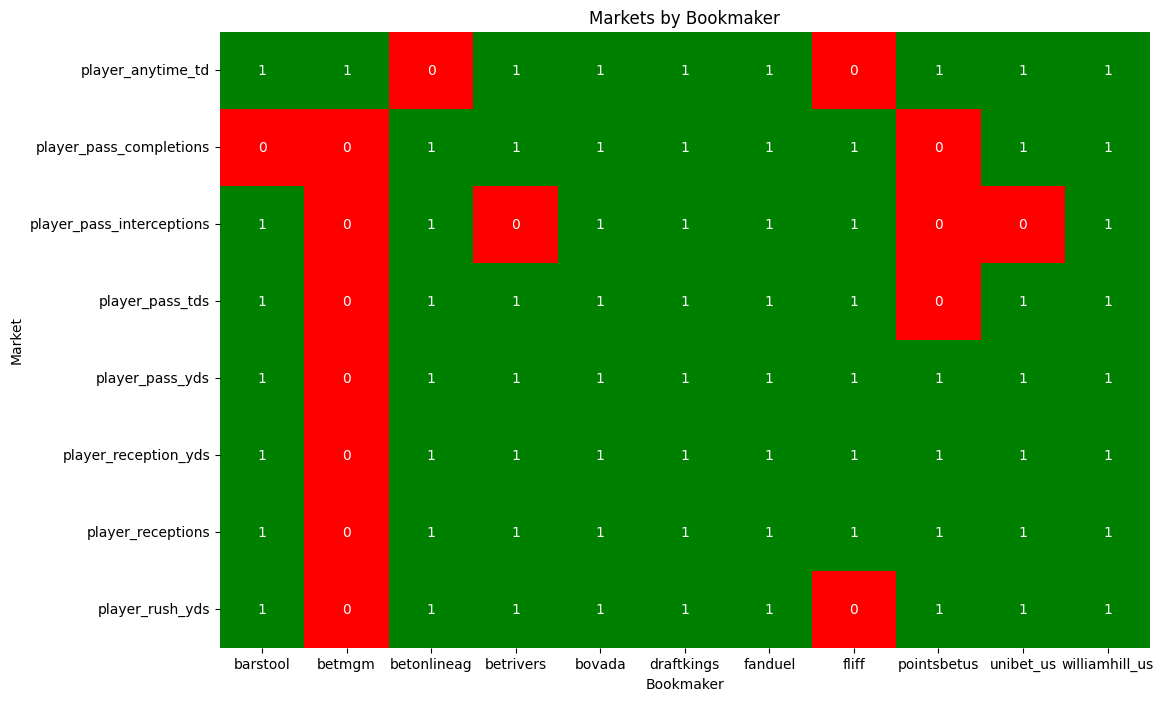

In [7]:
# Filter the DataFrame to only include rows with the specified markets
df_filtered = odds_df

# Drop bookmakers that don't have any of these markets
bookmakers_to_drop = df_filtered.groupby('bookmaker').filter(lambda x: len(set(x['market']) & set(markets_to_keep)) == 0)['bookmaker'].unique()
df_filtered = df_filtered[~df_filtered['bookmaker'].isin(bookmakers_to_drop)]

# Create a pivot table to visualize which bookmakers have which markets
pivot_df = pd.crosstab(df_filtered['market'], df_filtered['bookmaker'])

# Replace non-zero values with green and zero values with red
pivot_df = pivot_df.applymap(lambda x: 'green' if x > 0 else 'red')

# Plot the grid
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df.applymap(lambda x: 1 if x == 'green' else 0), annot=True, cbar=False, cmap=["red", "green"], xticklabels=pivot_df.columns, yticklabels=pivot_df.index)
plt.xlabel('Bookmaker')
plt.ylabel('Market')
plt.title('Markets by Bookmaker')
plt.show()


In [8]:
# Drop rows where bookmaker is 'Barstool Sportsbook'
odds_df = odds_df[odds_df['bookmaker'] != 'barstool']

# Now you can proceed with the rest of the analysis
df = odds_df

In [9]:
price_range_df = df.groupby('market')['price'].agg(['min', 'max']).reset_index()
price_range_df

,market,min,max
0,player_anytime_td,-255,15000
1,player_pass_completions,-136,104
2,player_pass_interceptions,-175,130
3,player_pass_tds,-300,215
4,player_pass_yds,-160,120
5,player_reception_yds,-145,110
6,player_receptions,-180,135
7,player_rush_yds,-150,115


In [72]:
# Function to get min and max for price and point along with corresponding description
def get_min_max(df, market):
    min_price_row = df[df['market'] == market].nsmallest(1, 'price')
    max_price_row = df[df['market'] == market].nlargest(1, 'price')
    min_point_row = df[df['market'] == market].nsmallest(1, 'point')
    max_point_row = df[df['market'] == market].nlargest(1, 'point')

    return {
        'market': market,
        'min_price': min_price_row['price'].values[0],
        'min_price_desc': min_price_row['description'].values[0],
        'max_price': max_price_row['price'].values[0],
        'max_price_desc': max_price_row['description'].values[0],
        'min_point': min_point_row['point'].values[0],
        'min_point_desc': min_point_row['description'].values[0],
        'max_point': max_point_row['point'].values[0],
        'max_point_desc': max_point_row['description'].values[0]
    }

# Get unique markets
unique_markets = df['market'].unique()

# Get min and max for each market
min_max_list = [get_min_max(df, market) for market in unique_markets]

# Create DataFrame
min_max_df = pd.DataFrame(min_max_list)

print(min_max_df)


                      market  min_price    min_price_desc  max_price  \
0          player_anytime_td       -155       Jalen Hurts      15000   
1    player_pass_completions       -140       Jordan Love        104   
2  player_pass_interceptions       -148        Jared Goff        112   
3            player_pass_tds       -300     Justin Fields        215   
4            player_pass_yds       -135       Jordan Love        105   
5       player_reception_yds       -142  Dontayvion Wicks        105   
6          player_receptions       -180       Romeo Doubs        134   
7            player_rush_yds       -135       Jordan Love       -101   

     max_price_desc  min_point    min_point_desc  max_point  max_point_desc  
0    Brandon Graham        NaN         AJ Dillon        NaN       AJ Dillon  
1       Jordan Love       18.5    Desmond Ridder       23.5      Jared Goff  
2        Jared Goff        0.5       Jordan Love        0.5     Jordan Love  
3     Justin Fields        1.5        J

In [73]:
# Group by 'market' and calculate the standard deviation for 'adjusted_point'
std_deviation_by_market = df.groupby('market')['point'].mean()

# Display the standard deviation for each market
print(std_deviation_by_market)


market
player_anytime_td                   NaN
player_pass_completions       21.447368
player_pass_interceptions      0.500000
player_pass_tds                1.500000
player_pass_yds              241.192308
player_reception_yds          45.567797
player_receptions              4.214286
player_rush_yds               37.062500
Name: point, dtype: float64


In [ ]:
# Assuming df is your DataFrame
unique_markets = df['market'].unique()

# Display the unique markets
print("Unique Markets:")
for market in unique_markets:
    print(market)


Unique Markets:
player_anytime_td
player_pass_completions
player_pass_interceptions
player_pass_tds
player_pass_yds
player_reception_yds
player_receptions
player_rush_yds


In [ ]:
import re

def preprocess_name(name):
    name = name.lower()  # Convert to lowercase
    name = re.sub(r'(jr\.|sr\.|ii|iii|iv|v)$', '', name)  # Remove suffixes at the end
    name = re.sub(r'\W+', '', name)  # Remove non-alphanumeric characters
    return name



    return cleaned_name

# Apply the function to the 'description' column
df['group_by_name'] = df['description'].apply(preprocess_name)




In [ ]:
df

,game_id,commence_time,in_play,bookmaker,last_update,home_team,away_team,market,label,description,price,point,group_by_name
24,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,Jalen Hurts,105,NaN,jalenhurts
25,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,A.J. Brown,140,NaN,ajbrown
26,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,D'Andre Swift,140,NaN,dandreswift
27,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,Rachaad White,140,NaN,rachaadwhite
28,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,Mike Evans,160,NaN,mikeevans
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3557,8251607b68015d2972e7f4b773149cb2,9/25/2023,FALSE,PointsBet (US),9/25/2023,Cincinnati Bengals,Los Angeles Rams,player_rush_yds,Under,Joe Mixon,-115,65.5,joemixon
3558,8251607b68015d2972e7f4b773149cb2,9/25/2023,FALSE,PointsBet (US),9/25/2023,Cincinnati Bengals,Los Angeles Rams,player_rush_yds,Over,Kyren Williams,-120,60.5,kyrenwilliams
3559,8251607b68015d2972e7f4b773149cb2,9/25/2023,FALSE,PointsBet (US),9/25/2023,Cincinnati Bengals,Los Angeles Rams,player_rush_yds,Under,Kyren Williams,-110,60.5,kyrenwilliams
3560,8251607b68015d2972e7f4b773149cb2,9/25/2023,FALSE,PointsBet (US),9/25/2023,Cincinnati Bengals,Los Angeles Rams,player_rush_yds,Over,Matthew Stafford,115,5.5,matthewstafford


In [ ]:
def calculate_implied_probability(price):
    if price > 0:
        return 100 / (price + 100)
    else:
        return abs(price) / (abs(price) + 100)

# Apply the function to the DataFrame
df['implied_probability'] = df['price'].apply(calculate_implied_probability)



In [ ]:
df

,game_id,commence_time,in_play,bookmaker,last_update,home_team,away_team,market,label,description,price,point,group_by_name,implied_probability
24,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,Jalen Hurts,105,NaN,jalenhurts,0.487805
25,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,A.J. Brown,140,NaN,ajbrown,0.416667
26,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,D'Andre Swift,140,NaN,dandreswift,0.416667
27,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,Rachaad White,140,NaN,rachaadwhite,0.416667
28,1e006c91ca2e69c339ed517495a2f428,9/25/2023,FALSE,DraftKings,9/25/2023,Tampa Bay Buccaneers,Philadelphia Eagles,player_anytime_td,Yes,Mike Evans,160,NaN,mikeevans,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3557,8251607b68015d2972e7f4b773149cb2,9/25/2023,FALSE,PointsBet (US),9/25/2023,Cincinnati Bengals,Los Angeles Rams,player_rush_yds,Under,Joe Mixon,-115,65.5,joemixon,0.534884
3558,8251607b68015d2972e7f4b773149cb2,9/25/2023,FALSE,PointsBet (US),9/25/2023,Cincinnati Bengals,Los Angeles Rams,player_rush_yds,Over,Kyren Williams,-120,60.5,kyrenwilliams,0.545455
3559,8251607b68015d2972e7f4b773149cb2,9/25/2023,FALSE,PointsBet (US),9/25/2023,Cincinnati Bengals,Los Angeles Rams,player_rush_yds,Under,Kyren Williams,-110,60.5,kyrenwilliams,0.523810
3560,8251607b68015d2972e7f4b773149cb2,9/25/2023,FALSE,PointsBet (US),9/25/2023,Cincinnati Bengals,Los Angeles Rams,player_rush_yds,Over,Matthew Stafford,115,5.5,matthewstafford,0.465116


In [ ]:
# First, aggregate the data
agg_df = df.groupby(['market', 'group_by_name', 'commence_time','label']).agg({
    'implied_probability': ['mean'],
    'point': 'first',
    'price':['mean'],
    'description': 'first'  # Assuming 'player_name' is a column in your DataFrame
}).reset_index()

# Flatten the MultiIndex after aggregation
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df.rename(columns= {'market_': 'market', 'commence_time_' : 'commence_time', 'description_first': 'description','point_first':'point',
                       'group_by_name_': 'group_by_name', 'label_': 'label'}, inplace=True)

# Now, sort the DataFrame
sorted_df = agg_df.sort_values(by=['implied_probability_mean','group_by_name'], ascending=[False, True])

sorted_df['implied_probability_mean'] = (sorted_df['implied_probability_mean'] * 100).round(2)


sorted_df = sorted_df[['description','market','label', 'implied_probability_mean',]]
# Display the sorted DataFrame
agg_df.columns

Index(['market', 'group_by_name', 'commence_time', 'label',
       'implied_probability_mean', 'point', 'price_mean', 'description'],
      dtype='object')

In [ ]:
pivot_df.columns


Index(['Barstool Sportsbook', 'BetMGM', 'BetOnline.ag', 'BetRivers',
       'DraftKings', 'FanDuel', 'PointsBet (US)', 'Unibet',
       'William Hill (US)'],
      dtype='object', name='bookmaker')

In [ ]:
# Pivot the DataFrame to have 'Over' and 'Under' as columns
pivot_df = agg_df.pivot(index=['market', 'group_by_name','point', 'commence_time'], columns='label', values=['implied_probability_mean','price_mean'])
pivot_df.reset_index(inplace=True)

pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.columns
pivot_df.rename(columns= {'market_': 'market', 'description_': 'description', 'commence_time_':'commence_time','point_':'point',
                       'group_by_name_': 'group_by_name'}, inplace=True)

pivot_df['excess_probability'] = abs(pivot_df['implied_probability_mean_Over'] - pivot_df['implied_probability_mean_Under'])



# Merge back with the original DataFrame to get the description
final_df = pd.merge(pivot_df, agg_df[['market', 'group_by_name', 'commence_time','description','implied_probability_mean']].drop_duplicates(), on=['market', 'group_by_name','commence_time'])

# Sort by excess_probability and player name
final_df = final_df.sort_values(by=['excess_probability', 'group_by_name'], ascending=[False, True])

# Select the columns to display
final_df = final_df[['description', 'market', 'group_by_name', 'point', 'implied_probability_mean_Over',
       'implied_probability_mean_Under', 'implied_probability_mean_Yes',
       'price_mean_Over', 'price_mean_Under', 'price_mean_Yes','commence_time',
       'excess_probability']]
# Display the sorted DataFrame
print(final_df)


          description                     market    group_by_name  point  \
199   Deven Thompkins          player_receptions   deventhompkins    1.5   
200   Deven Thompkins          player_receptions   deventhompkins    1.5   
117       Jalen Hurts  player_pass_interceptions       jalenhurts    0.5   
118       Jalen Hurts  player_pass_interceptions       jalenhurts    0.5   
209         Joe Mixon          player_receptions         joemixon    4.5   
..                ...                        ...              ...    ...   
102  William Gholston          player_anytime_td  williamgholston    NaN   
103        YaYa Diaby          player_anytime_td        yayadiaby    NaN   
104   Zach Cunningham          player_anytime_td   zachcunningham    NaN   
105        Zach Evans          player_anytime_td        zachevans    NaN   
106     Zyon McCollum          player_anytime_td     zyonmccollum    NaN   

     implied_probability_mean_Over  implied_probability_mean_Under  \
199              

In [ ]:
# Add a 'pick' column based on the conditions
final_df['pick'] = final_df.apply(lambda row: 1 if (row['excess_probability'] > 0 and row['implied_probability_mean_Over'] > row['implied_probability_mean_Under']) else
                                  -1 if (row['excess_probability'] > 0 and row['implied_probability_mean_Under'] > row['implied_probability_mean_Over']) else
                                  0, axis=1)

# Display the updated DataFrame
final_df.sort_values(by=['excess_probability','description'], ascending=[False, True])


,description,market,group_by_name,point,implied_probability_mean_Over,implied_probability_mean_Under,implied_probability_mean_Yes,price_mean_Over,price_mean_Under,price_mean_Yes,commence_time,excess_probability,pick
199,Deven Thompkins,player_receptions,deventhompkins,1.5,0.380382,0.688793,NaN,194.142857,-295.285714,NaN,9/25/2023,0.308411,-1
200,Deven Thompkins,player_receptions,deventhompkins,1.5,0.380382,0.688793,NaN,194.142857,-295.285714,NaN,9/25/2023,0.308411,-1
117,Jalen Hurts,player_pass_interceptions,jalenhurts,0.5,0.410651,0.657430,NaN,143.833333,-192.666667,NaN,9/25/2023,0.246779,-1
118,Jalen Hurts,player_pass_interceptions,jalenhurts,0.5,0.410651,0.657430,NaN,143.833333,-192.666667,NaN,9/25/2023,0.246779,-1
209,Joe Mixon,player_receptions,joemixon,4.5,0.418038,0.648555,NaN,116.818182,-181.454545,NaN,9/25/2023,0.230517,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,William Gholston,player_anytime_td,williamgholston,NaN,NaN,NaN,0.007937,NaN,NaN,12500.0,9/25/2023,NaN,0
103,YaYa Diaby,player_anytime_td,yayadiaby,NaN,NaN,NaN,0.012346,NaN,NaN,8000.0,9/25/2023,NaN,0
104,Zach Cunningham,player_anytime_td,zachcunningham,NaN,NaN,NaN,0.032258,NaN,NaN,3000.0,9/25/2023,NaN,0
105,Zach Evans,player_anytime_td,zachevans,NaN,NaN,NaN,0.085947,NaN,NaN,1090.0,9/25/2023,NaN,0


In [ ]:
# Function to set the value of 'implied_probability_mean'
def set_implied_probability(row):
    if row['pick'] == -1:
        return row['implied_probability_mean_Under']
    elif row['pick'] == 1:
        return row['implied_probability_mean_Over']
    else:
        return row['implied_probability_mean_Over']  # or Under, doesn't matter if pick is 0

# Apply the function
final_df['implied_probability_mean'] = final_df.apply(set_implied_probability, axis=1)

# Now proceed with the sorting and dropping duplicates
final_df.sort_values(by=['group_by_name', 'market', 'implied_probability_mean'], ascending=[True, True, False], inplace=True)
final_df.drop_duplicates(subset=['group_by_name', 'market'], keep='first', inplace=True)

# Rename and select columns
final_df = final_df.rename(columns={
    'description': 'player_name',
    'group_by_name': 'merge_name',
    'implied_probability_mean_Yes': 'touchdown_probability'
})

final_df = final_df[['player_name', 'merge_name', 'market', 'point', 'implied_probability_mean','touchdown_probability', 'excess_probability', 'pick','commence_time']]


In [ ]:
final_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 0 to 106
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_name               181 non-null    object 
 1   merge_name                181 non-null    object 
 2   market                    181 non-null    object 
 3   point                     74 non-null     float64
 4   implied_probability_mean  74 non-null     float64
 5   touchdown_probability     107 non-null    float64
 6   excess_probability        73 non-null     float64
 7   pick                      181 non-null    int64  
 8   commence_time             181 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 14.1+ KB


In [ ]:
final_df.columns

Index(['player_name', 'merge_name', 'market', 'point',
       'implied_probability_mean', 'touchdown_probability',
       'excess_probability', 'pick', 'commence_time'],
      dtype='object')

In [ ]:
# Count the number of unique descriptions for each bookmaker
unique_desc_count = final_df['merge_name'].nunique()

# Display the result
print("Number of Unique Descriptions by Bookmaker:")
print(unique_desc_count)


Number of Unique Descriptions by Bookmaker:
108


In [ ]:
years = list(np.arange(2016, 2024))


In [ ]:
years

[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

In [ ]:
weekly_columns = ['player_display_name', 'position','season','week','season_type',
                  'recent_team','passing_yards','passing_tds','interceptions',
                   'rushing_yards', 'rushing_tds', 'receptions','receiving_yards','receiving_tds',]

In [ ]:
nfl_weekly = nfl.import_weekly_data(years, weekly_columns)


Downcasting floats.


In [ ]:
# Apply the function to the 'description' column
nfl_weekly['merge_name'] = nfl_weekly['player_display_name'].apply(preprocess_name)

In [ ]:
nfl_weekly[nfl_weekly['merge_name'] == 'brianrobinson']

,player_display_name,position,season,week,season_type,recent_team,passing_yards,passing_tds,interceptions,rushing_yards,rushing_tds,receptions,receiving_yards,receiving_tds,merge_name
5362,Brian Robinson,RB,2022,5,REG,WAS,0.0,0,0.0,22.0,0,0,0.0,0,brianrobinson
5363,Brian Robinson,RB,2022,6,REG,WAS,0.0,0,0.0,60.0,1,0,0.0,0,brianrobinson
5364,Brian Robinson,RB,2022,7,REG,WAS,0.0,0,0.0,73.0,0,2,13.0,0,brianrobinson
5365,Brian Robinson,RB,2022,8,REG,WAS,0.0,0,0.0,20.0,0,0,0.0,0,brianrobinson
5366,Brian Robinson,RB,2022,9,REG,WAS,0.0,0,0.0,44.0,0,2,-6.0,0,brianrobinson
5367,Brian Robinson,RB,2022,10,REG,WAS,0.0,0,0.0,86.0,1,0,0.0,0,brianrobinson
5368,Brian Robinson,RB,2022,11,REG,WAS,0.0,0,0.0,57.0,0,0,0.0,0,brianrobinson
5369,Brian Robinson,RB,2022,12,REG,WAS,0.0,0,0.0,105.0,0,2,20.0,1,brianrobinson
5370,Brian Robinson,RB,2022,13,REG,WAS,0.0,0,0.0,96.0,0,2,15.0,0,brianrobinson
5371,Brian Robinson,RB,2022,15,REG,WAS,0.0,0,0.0,89.0,0,1,18.0,0,brianrobinson


In [ ]:
final_df[final_df['merge_name'] == 'brianrobinson']

,player_name,merge_name,market,point,implied_probability_mean,touchdown_probability,excess_probability,pick,commence_time


In [ ]:
def calculate_draftkings_points(row):
    points = 0
    points += 4 * row['passing_tds']
    points += 0.04 * row['passing_yards']
    points += 3 if row['passing_yards'] >= 300 else 0
    points -= row['interceptions']
    points += 6 * row['rushing_tds']
    points += 0.1 * row['rushing_yards']
    points += 3 if row['rushing_yards'] >= 100 else 0
    points += 6 * row['receiving_tds']
    points += 0.1 * row['receiving_yards']
    points += 3 if row['receiving_yards'] >= 100 else 0
    points += row['receptions']
    return points

nfl_weekly['draftkings_fantasy_points'] = nfl_weekly.apply(calculate_draftkings_points, axis=1)

nfl_weekly[['player_display_name', 'season','week','draftkings_fantasy_points']].sort_values(by='draftkings_fantasy_points',ascending=False)




,player_display_name,season,week,draftkings_fantasy_points
1979,Tyreek Hill,2020,12,60.90
2838,Alvin Kamara,2020,16,59.20
5397,Ja'Marr Chase,2021,17,58.60
1823,Joe Mixon,2022,9,58.10
2761,Will Fuller,2019,5,56.70
...,...,...,...,...
4735,Kyle Lauletta,2018,14,-1.20
2733,Teddy Bridgewater,2017,15,-1.30
5314,Nathan Peterman,2017,11,-1.96
393,Sam Koch,2016,12,-2.30


In [ ]:
nfl_weekly

,player_display_name,position,season,week,season_type,recent_team,passing_yards,passing_tds,interceptions,rushing_yards,rushing_tds,receptions,receiving_yards,receiving_tds,merge_name,draftkings_fantasy_points
0,Tom Brady,QB,2016,5,REG,NE,406.0,3,0.0,14.0,0,0,0.0,0,tombrady,32.64
1,Tom Brady,QB,2016,6,REG,NE,376.0,3,0.0,2.0,0,0,0.0,0,tombrady,30.24
2,Tom Brady,QB,2016,7,REG,NE,222.0,2,0.0,13.0,0,0,0.0,0,tombrady,18.18
3,Tom Brady,QB,2016,8,REG,NE,315.0,4,0.0,15.0,0,0,0.0,0,tombrady,33.10
4,Tom Brady,QB,2016,10,REG,NE,316.0,0,1.0,7.0,0,0,0.0,0,tombrady,15.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,Anthony Richardson,QB,2023,1,REG,IND,223.0,1,1.0,40.0,1,0,0.0,0,anthonyrichardson,21.92
901,Anthony Richardson,QB,2023,2,REG,IND,56.0,0,0.0,35.0,2,0,0.0,0,anthonyrichardson,17.74
902,Zach Charbonnet,RB,2023,1,REG,SEA,0.0,0,0.0,11.0,0,0,0.0,0,zachcharbonnet,1.10
903,Zach Charbonnet,RB,2023,2,REG,SEA,0.0,0,0.0,16.0,0,2,14.0,0,zachcharbonnet,5.00


In [ ]:
nfl_weekly.columns

Index(['player_display_name', 'position', 'season', 'week', 'season_type',
       'recent_team', 'passing_yards', 'passing_tds', 'interceptions',
       'rushing_yards', 'rushing_tds', 'receptions', 'receiving_yards',
       'receiving_tds', 'merge_name', 'draftkings_fantasy_points'],
      dtype='object')

In [ ]:
# Conditionally fill nulls in 'point' column
final_df.loc[(final_df['point'].isna()) & (final_df['market'] == 'player_anytime_td'), 'point'] = final_df['touchdown_probability']

# Verify the changes
print(final_df[(final_df['market'] == 'player_anytime_td')][['point', 'touchdown_probability']].head())


      point  touchdown_probability
0  0.435244               0.435244
1  0.032258               0.032258
2  0.068697               0.068697
3  0.047619               0.047619
4  0.013158               0.013158


In [ ]:
final_df.columns

Index(['player_name', 'merge_name', 'market', 'point',
       'implied_probability_mean', 'touchdown_probability',
       'excess_probability', 'pick', 'commence_time'],
      dtype='object')

In [ ]:
# Pivot the DataFrame to have 'Over' and 'Under' as columns
pivot_df = final_df.pivot(index=['merge_name','commence_time'], columns='market', values=['point','pick','implied_probability_mean', 'excess_probability'])
pivot_df.reset_index(inplace=True)

pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.columns
pivot_df.rename(columns= {'player_name_': 'player_name', 'commence_time_': 'commence_time',
                       'merge_name_': 'merge_name'}, inplace=True)

# Sort by excess_probability and player name
final_df = pivot_df.sort_values(by=['merge_name'], ascending=[True])

# Group by 'merge_name' and 'player_name' and take the maximum value for each column


In [ ]:
final_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 0 to 107
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   merge_name                                          108 non-null    object 
 1   commence_time                                       108 non-null    object 
 2   point_player_anytime_td                             107 non-null    float64
 3   point_player_pass_completions                       4 non-null      float64
 4   point_player_pass_interceptions                     4 non-null      float64
 5   point_player_pass_tds                               4 non-null      float64
 6   point_player_pass_yds                               4 non-null      float64
 7   point_player_reception_yds                          25 non-null     float64
 8   point_player_receptions                             24 non-null     float64
 9  

In [ ]:
final_df = final_df[['merge_name', 'commence_time',
       'point_player_pass_interceptions',
       'point_player_pass_tds',
       'point_player_pass_yds',
       'point_player_reception_yds',
       'point_player_receptions',
       'point_player_rush_yds',
        'pick_player_pass_completions',
       'pick_player_pass_interceptions',
       'pick_player_pass_tds',
       'pick_player_pass_yds',
       'pick_player_reception_yds',
       'pick_player_receptions',
       'pick_player_rush_yds',
       'point_player_anytime_td',
       'implied_probability_mean_player_pass_completions',
       'implied_probability_mean_player_pass_interceptions',
       'implied_probability_mean_player_pass_tds',
       'implied_probability_mean_player_pass_yds',
       'implied_probability_mean_player_reception_yds',
       'implied_probability_mean_player_receptions',
       'implied_probability_mean_player_rush_yds',
       'excess_probability_player_pass_completions',
       'excess_probability_player_pass_interceptions',
       'excess_probability_player_pass_tds',
       'excess_probability_player_pass_yds',
       'excess_probability_player_reception_yds',
       'excess_probability_player_receptions',
       'excess_probability_player_rush_yds',
    ]]

In [ ]:
final_df.rename(columns={
    'point_player_pass_interceptions': 'raw_pass_interceptions',
    'point_player_pass_tds': 'raw_pass_tds',
    'point_player_pass_yds': 'raw_player_pass_yards',
    'point_player_reception_yds': 'raw_receiving_yards',
    'point_player_receptions': 'raw_receptions',
    'point_player_rush_yds': 'raw_rushing_yards',
    'pick_player_pass_completions' : 'pick_completions' ,
    'pick_player_pass_interceptions' : 'pick_interceptions',
    'pick_player_pass_tds' : 'pick_passing_tds',
    'pick_player_pass_yds' : 'pick_passing_yards',
    'pick_player_reception_yds' : 'pick_receiving_yards',
    'pick_player_receptions': 'pick_receptions',
    'pick_player_rush_yds' : 'pick_rushing_yards',
    'point_player_anytime_td': 'implied_rushing_or_receiving_tds',
    'implied_probability_mean_player_pass_interceptions': 'implied_probability_interceptions',
    'implied_probability_mean_player_pass_tds': 'implied_probability_passing_tds',
    'implied_probability_mean_player_pass_yds': 'implied_probability_passing_yards',
    'implied_probability_mean_player_reception_yds': 'implied_probability_receiving_yards',
    'implied_probability_mean_player_receptions': 'implied_probability_receptions',
    'implied_probability_mean_player_rush_yds': 'implied_probability_rushing_yards',
    'excess_probability_player_pass_interceptions': 'excess_probability_interceptions',
    'excess_probability_player_pass_tds': 'excess_probability_passing_tds',
    'excess_probability_player_pass_yds': 'excess_probability_passing_yards',
    'excess_probability_player_reception_yds': 'excess_probability_receiving_yards',
    'excess_probability_player_receptions': 'excess_probability_receptions',
    'excess_probability_player_rush_yds': 'excess_probability_rushing_yards',
    'pick_player_pass_completions' : 'pick_completions' ,
    'pick_player_pass_interceptions' : 'pick_interceptions',
    'pick_player_pass_tds' : 'pick_passing_tds',
    'pick_player_pass_yds' : 'pick_passing_yardds',
    'pick_player_reception_yds' : 'pick_receiving_yards',
    'pick_player_receptions': 'pick_receptions',
    'pick_player_rush_yds' : 'pick_rushing_yards'
}, inplace=True)


<ipython-input-1588-81a6e7f3cd5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={


In [ ]:
final_df = final_df.groupby('merge_name').max().reset_index()

# This will leave you with a DataFrame where each 'merge_name' and 'player_name' combination has only one row.

# Display the sorted DataFrame
final_df.columns

Index(['merge_name', 'commence_time', 'raw_pass_interceptions', 'raw_pass_tds',
       'raw_player_pass_yards', 'raw_receiving_yards', 'raw_receptions',
       'raw_rushing_yards', 'pick_completions', 'pick_interceptions',
       'pick_passing_tds', 'pick_passing_yardds', 'pick_receiving_yards',
       'pick_receptions', 'pick_rushing_yards',
       'implied_rushing_or_receiving_tds',
       'implied_probability_mean_player_pass_completions',
       'implied_probability_interceptions', 'implied_probability_passing_tds',
       'implied_probability_passing_yards',
       'implied_probability_receiving_yards', 'implied_probability_receptions',
       'implied_probability_rushing_yards',
       'excess_probability_player_pass_completions',
       'excess_probability_interceptions', 'excess_probability_passing_tds',
       'excess_probability_passing_yards',
       'excess_probability_receiving_yards', 'excess_probability_receptions',
       'excess_probability_rushing_yards'],
      dtype

In [ ]:
final_df[final_df['merge_name']=='brianrobinson']

,merge_name,commence_time,raw_pass_interceptions,raw_pass_tds,raw_player_pass_yards,raw_receiving_yards,raw_receptions,raw_rushing_yards,pick_completions,pick_interceptions,...,implied_probability_receiving_yards,implied_probability_receptions,implied_probability_rushing_yards,excess_probability_player_pass_completions,excess_probability_interceptions,excess_probability_passing_tds,excess_probability_passing_yards,excess_probability_receiving_yards,excess_probability_receptions,excess_probability_rushing_yards


In [ ]:
import pandas as pd

# Assuming you have a DataFrame named 'df' with the provided data
# You can filter the data based on the given criteria
filtered_data = nfl_weekly[(nfl_weekly['season'] == 2023) & (nfl_weekly['week'] == 3) & (nfl_weekly['season_type'] == 'REG')]

# Select the desired columns
selected_columns = filtered_data[['player_display_name', 'merge_name', 'position', 'season', 'week', 'draftkings_fantasy_points']]

# Print the result


In [ ]:
nfl_weekly.dtypes

player_display_name           object
position                      object
season                         int32
week                           int32
season_type                   object
recent_team                   object
passing_yards                float32
passing_tds                    int32
interceptions                float32
rushing_yards                float32
rushing_tds                    int32
receptions                     int32
receiving_yards              float32
receiving_tds                  int32
merge_name                    object
draftkings_fantasy_points    float64
dtype: object

In [ ]:
nfl_weekly

,player_display_name,position,season,week,season_type,recent_team,passing_yards,passing_tds,interceptions,rushing_yards,rushing_tds,receptions,receiving_yards,receiving_tds,merge_name,draftkings_fantasy_points
0,Tom Brady,QB,2016,5,REG,NE,406.0,3,0.0,14.0,0,0,0.0,0,tombrady,32.64
1,Tom Brady,QB,2016,6,REG,NE,376.0,3,0.0,2.0,0,0,0.0,0,tombrady,30.24
2,Tom Brady,QB,2016,7,REG,NE,222.0,2,0.0,13.0,0,0,0.0,0,tombrady,18.18
3,Tom Brady,QB,2016,8,REG,NE,315.0,4,0.0,15.0,0,0,0.0,0,tombrady,33.10
4,Tom Brady,QB,2016,10,REG,NE,316.0,0,1.0,7.0,0,0,0.0,0,tombrady,15.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,Anthony Richardson,QB,2023,1,REG,IND,223.0,1,1.0,40.0,1,0,0.0,0,anthonyrichardson,21.92
901,Anthony Richardson,QB,2023,2,REG,IND,56.0,0,0.0,35.0,2,0,0.0,0,anthonyrichardson,17.74
902,Zach Charbonnet,RB,2023,1,REG,SEA,0.0,0,0.0,11.0,0,0,0.0,0,zachcharbonnet,1.10
903,Zach Charbonnet,RB,2023,2,REG,SEA,0.0,0,0.0,16.0,0,2,14.0,0,zachcharbonnet,5.00


In [ ]:
#Todo...
# #merge onto the other df
# calculate the touchdown probabilities and map those as implied touchdowns
# calculate the non adjusted draftkings points.
# calculated implied points based on the excess probability and the career standar deviation since 2016.
# adjust based on the players career standard deviation - perhaps compare to see how many standard deviations it
# is away from the career average and then adjust accordingly
# then calcualted the implied draftking spoints
# compare for game already played
# iterate
# nail down the projections as best you can and then start the process of getting them optimizer ready and draftkings id

# Filter rows where season_type is not "REG"
df_players = nfl_weekly[nfl_weekly['season_type'] == 'REG']
df_players.sort_values(by=['season','week'], ascending=[False,False],inplace=True)

# Aggregate data
aggregated_data = df_players.groupby(['player_display_name','merge_name']).agg({
       'recent_team': 'first',
       'position':'first',
        'week': 'sum',
        'draftkings_fantasy_points' : ['mean','std'],
       'passing_yards': ['mean','std'],
       'passing_tds' : ['mean','std'],
       'interceptions' : ['mean','std'],
       'rushing_yards' : ['mean','std'],
       'rushing_tds' : ['mean','std'],
       'receptions': ['mean','std'],
       'receiving_yards' : ['mean','std'],
       'receiving_tds' : ['mean','std']
}).reset_index()

# Flatten the MultiIndex
aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]
print(aggregated_data.columns)
# Rename the columns
aggregated_data.rename(columns={
    'player_display_name_' : 'player_display_name',
    'merge_name_': 'merge_name',
    'position_first': 'most_recent_position',
    'week_sum': 'career_games' , # Number of unique weeks
    'recent_team_first': 'most_recent_team',
    'passing_yards_mean': 'career_passing_yards_mean',
    'passing_yards_std': 'career_passing_yards_std',
    'passing_tds_mean': 'career_passing_tds_mean',
    'passing_tds_std': 'career_passing_tds_std',
    'interceptions_mean': 'career_interceptions_mean',
    'interceptions_std': 'career_interceptions_std',
    'rushing_yards_mean': 'career_rushing_yards_mean',
    'rushing_yards_std': 'career_rushing_yards_std',
    'rushing_tds_mean': 'career_rushing_tds_mean',
    'rushing_tds_std': 'career_rushing_tds_std',
    'receptions_mean': 'career_receptions_mean',
    'receptions_std': 'career_receptions_std',
    'receiving_yards_mean': 'career_receiving_yards_mean',
    'receiving_yards_std': 'career_receiving_yards_std',
    'receiving_tds_mean': 'career_receiving_tds_mean',
    'receiving_tds_std': 'career_receiving_tds_std',
    'draftkings_fantasy_points_mean': 'career_draftkings_mean',
    'draftkings_fantasy_points_std': 'career_draftkings_points_std'
}, inplace=True)

# Merge with team data
career_data = aggregated_data


<ipython-input-1594-84fb4a076575>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.sort_values(by=['season','week'], ascending=[False,False],inplace=True)


Index(['player_display_name_', 'merge_name_', 'recent_team_first',
       'position_first', 'week_sum', 'draftkings_fantasy_points_mean',
       'draftkings_fantasy_points_std', 'passing_yards_mean',
       'passing_yards_std', 'passing_tds_mean', 'passing_tds_std',
       'interceptions_mean', 'interceptions_std', 'rushing_yards_mean',
       'rushing_yards_std', 'rushing_tds_mean', 'rushing_tds_std',
       'receptions_mean', 'receptions_std', 'receiving_yards_mean',
       'receiving_yards_std', 'receiving_tds_mean', 'receiving_tds_std'],
      dtype='object')


In [ ]:
career_data[career_data['merge_name']=='brianrobinson']

,player_display_name,merge_name,most_recent_team,most_recent_position,career_games,career_draftkings_mean,career_draftkings_points_std,career_passing_yards_mean,career_passing_yards_std,career_passing_tds_mean,...,career_rushing_yards_mean,career_rushing_yards_std,career_rushing_tds_mean,career_rushing_tds_std,career_receptions_mean,career_receptions_std,career_receiving_yards_mean,career_receiving_yards_std,career_receiving_tds_mean,career_receiving_tds_std
185,Brian Robinson,brianrobinson,WAS,RB,135,10.88,7.05349,0.0,0.0,0.0,...,67.533333,25.393663,0.266667,0.593617,0.8,0.941124,7.266667,12.464044,0.133333,0.351866


In [ ]:
final_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   merge_name                                        108 non-null    object 
 1   commence_time                                     108 non-null    object 
 2   raw_pass_interceptions                            4 non-null      float64
 3   raw_pass_tds                                      4 non-null      float64
 4   raw_player_pass_yards                             4 non-null      float64
 5   raw_receiving_yards                               25 non-null     float64
 6   raw_receptions                                    24 non-null     float64
 7   raw_rushing_yards                                 9 non-null      float64
 8   pick_completions                                  4 non-null      float64
 9   pick_interceptions   

In [ ]:
# Step 1: Merge the DataFrames
merged_df = pd.merge(final_df, career_data, on='merge_name', how='left')

# Step 2: Create the Combined TD Mean Column
merged_df['career_rushing_or_receiving_tds_mean'] = merged_df['career_rushing_tds_mean'] + merged_df['career_receiving_tds_mean']

# Display the first few rows of the merged DataFrame to check
merged_df

,merge_name,commence_time,raw_pass_interceptions,raw_pass_tds,raw_player_pass_yards,raw_receiving_yards,raw_receptions,raw_rushing_yards,pick_completions,pick_interceptions,...,career_rushing_yards_std,career_rushing_tds_mean,career_rushing_tds_std,career_receptions_mean,career_receptions_std,career_receiving_yards_mean,career_receiving_yards_std,career_receiving_tds_mean,career_receiving_tds_std,career_rushing_or_receiving_tds_mean
0,ajbrown,9/25/2023,NaN,NaN,NaN,70.5,5.5,NaN,NaN,NaN,...,6.469307,0.016129,0.127,4.580645,2.446465,74.177422,46.102354,0.564516,0.692370,0.580645
1,albertokwuegbunam,9/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000,2.347826,1.824298,23.739130,21.774083,0.173913,0.387553,0.173913
2,andreiiosivas,9/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,andreiiosivias,9/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,anthonynelson,9/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,williamgholston,9/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,yayadiaby,9/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,zachcunningham,9/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,zachevans,9/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mapping = {
    'raw_pass_interceptions': ('career_interceptions_std', 'pick_interceptions', 'excess_probability_interceptions'),
    'raw_pass_tds': ('career_passing_tds_std', 'pick_passing_tds', 'excess_probability_passing_tds'),
    'raw_player_pass_yards': ('career_passing_yards_std', 'pick_passing_yardds', 'excess_probability_passing_yards'),
    'raw_receiving_yards': ('career_receiving_yards_std', 'pick_receiving_yards', 'excess_probability_receiving_yards'),
    'raw_receptions': ('career_receptions_std', 'pick_receptions', 'excess_probability_receptions'),
    'raw_rushing_yards': ('career_rushing_yards_std', 'pick_rushing_yards', 'excess_probability_rushing_yards'),
}

# Create new columns for the implied statistics
for raw_stat, (career_std, pick_col, excess_prob_col) in mapping.items():
    implied_stat = f'implied_{raw_stat[4:]}'  # Create the name for the new "implied" column
    merged_df[implied_stat] = merged_df.apply(
        lambda row: row[raw_stat] + (row[career_std] * row[excess_prob_col]) if row[pick_col] == 1 else
                    (row[raw_stat] - (row[career_std] * row[excess_prob_col]) if row[pick_col] == -1 else row[raw_stat]),
        axis=1
    )
# Select a subset of columns for inspection
cols_to_check = ['merge_name','raw_pass_interceptions', 'implied_pass_interceptions','excess_probability_interceptions','career_interceptions_mean', 'pick_interceptions', 'career_interceptions_std']

# Filter out rows where the relevant columns are null
filtered_df = merged_df[merged_df['raw_pass_interceptions'].notna() & merged_df['implied_pass_interceptions'].notna()]

# Display the filtered DataFrame
print(filtered_df[cols_to_check].head())




         merge_name  raw_pass_interceptions  implied_pass_interceptions  \
7     bakermayfield                     0.5                    0.363175   
45       jalenhurts                     0.5                    0.322409   
50        joeburrow                     0.5                    0.435170   
67  matthewstafford                     0.5                    0.401134   

    excess_probability_interceptions  career_interceptions_mean  \
7                           0.139083                   0.864865   
45                          0.246779                   0.434783   
50                          0.070148                   0.727273   
67                          0.113055                   0.730000   

    pick_interceptions  career_interceptions_std  
7                 -1.0                  0.983763  
45                -1.0                  0.719635  
50                -1.0                  0.924188  
67                -1.0                  0.874498  


In [ ]:
merged_df.columns

Index(['merge_name', 'commence_time', 'raw_pass_interceptions', 'raw_pass_tds',
       'raw_player_pass_yards', 'raw_receiving_yards', 'raw_receptions',
       'raw_rushing_yards', 'pick_completions', 'pick_interceptions',
       'pick_passing_tds', 'pick_passing_yardds', 'pick_receiving_yards',
       'pick_receptions', 'pick_rushing_yards',
       'implied_rushing_or_receiving_tds',
       'implied_probability_mean_player_pass_completions',
       'implied_probability_interceptions', 'implied_probability_passing_tds',
       'implied_probability_passing_yards',
       'implied_probability_receiving_yards', 'implied_probability_receptions',
       'implied_probability_rushing_yards',
       'excess_probability_player_pass_completions',
       'excess_probability_interceptions', 'excess_probability_passing_tds',
       'excess_probability_passing_yards',
       'excess_probability_receiving_yards', 'excess_probability_receptions',
       'excess_probability_rushing_yards', 'player_disp

In [ ]:
# Define the new order for the columns
ordered_columns = [
    # Identifiers and basic information
    'merge_name', 'commence_time','player_display_name', 'most_recent_team', 'most_recent_position',

        # Implied statistics
    'implied_rushing_or_receiving_tds',
    'implied_pass_interceptions', 'implied_pass_tds', 'implied_player_pass_yards',
    'implied_receiving_yards', 'implied_receptions', 'implied_rushing_yards',
    # Career statistics
    'career_draftkings_mean', 'career_draftkings_points_std',
    'career_passing_yards_mean', 'career_passing_yards_std',
    'career_passing_tds_mean', 'career_passing_tds_std',
    'career_interceptions_mean', 'career_interceptions_std',
    'career_rushing_yards_mean', 'career_rushing_yards_std',
    'career_receptions_mean', 'career_receptions_std',
    'career_receiving_yards_mean', 'career_receiving_yards_std',
    'career_rushing_or_receiving_tds_mean',

    # Raw statistics
    'raw_pass_interceptions', 'raw_pass_tds', 'raw_player_pass_yards',
    'raw_receiving_yards', 'raw_receptions', 'raw_rushing_yards']



# Apply the new order
merged_df = merged_df[ordered_columns]

# Display the first few rows to check


In [ ]:
merged_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 0 to 107
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   merge_name                            108 non-null    object 
 1   commence_time                         108 non-null    object 
 2   player_display_name                   50 non-null     object 
 3   most_recent_team                      50 non-null     object 
 4   most_recent_position                  50 non-null     object 
 5   implied_rushing_or_receiving_tds      107 non-null    float64
 6   implied_pass_interceptions            4 non-null      float64
 7   implied_pass_tds                      4 non-null      float64
 8   implied_player_pass_yards             4 non-null      float64
 9   implied_receiving_yards               25 non-null     float64
 10  implied_receptions                    23 non-null     float64
 11  implied_rushing_yar

In [ ]:
import pandas as pd

def calculate_implied_draftkings_points(row):
    points = 0
    if pd.notna(row['implied_pass_tds']):
        points += 4 * row['implied_pass_tds']
    if pd.notna(row['implied_player_pass_yards']):
        points += 0.04 * row['implied_player_pass_yards']
        points += 3 if row['implied_player_pass_yards'] >= 300 else 0
    if pd.notna(row['implied_pass_interceptions']):
        points -= row['implied_pass_interceptions']
    if pd.notna(row['implied_rushing_yards']):
        points += 0.1 * row['implied_rushing_yards']
        points += 3 if row['implied_rushing_yards'] >= 100 else 0
    if pd.notna(row['implied_rushing_or_receiving_tds']):
        points += 6 * row['implied_rushing_or_receiving_tds']
    if pd.notna(row['implied_receiving_yards']):
        points += 0.1 * row['implied_receiving_yards']
        points += 3 if row['implied_receiving_yards'] >= 100 else 0
    if pd.notna(row['implied_receptions']):
        points += row['implied_receptions']
    return points

merged_df['implied_draftkings_fantasy_points'] = merged_df.apply(calculate_implied_draftkings_points, axis=1)

<ipython-input-1602-bf786cf0c479>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['implied_draftkings_fantasy_points'] = merged_df.apply(calculate_implied_draftkings_points, axis=1)


In [ ]:
test_df = merged_df[['merge_name','commence_time','player_display_name', 'most_recent_position', 'most_recent_team','career_draftkings_mean','implied_draftkings_fantasy_points']].sort_values(by='implied_draftkings_fantasy_points', ascending=False)
test_df.dropna(subset='player_display_name')

,merge_name,commence_time,player_display_name,most_recent_position,most_recent_team,career_draftkings_mean,implied_draftkings_fantasy_points
45,jalenhurts,9/25/2023,Jalen Hurts,QB,PHI,19.370870,21.844965
46,jamarrchase,9/25/2023,Ja'Marr Chase,WR,CIN,19.264516,16.780309
7,bakermayfield,9/25/2023,Baker Mayfield,QB,TB,15.763784,16.663301
50,joeburrow,9/25/2023,Joe Burrow,QB,CIN,21.527727,16.538054
67,matthewstafford,9/25/2023,Matthew Stafford,QB,LA,18.492800,16.517931
51,joemixon,9/25/2023,Joe Mixon,RB,CIN,15.986585,16.380602
79,pukanacua,9/25/2023,Puka Nacua,WR,LA,29.000000,15.844985
0,ajbrown,9/25/2023,A.J. Brown,WR,PHI,16.417742,14.800464
61,kyrenwilliams,9/25/2023,Kyren Williams,RB,LA,7.590000,14.611339
93,teehiggins,9/25/2023,Tee Higgins,WR,CIN,15.411111,14.375450


In [ ]:
# Filter rows where 'player_display_name' is NaN and 'implied_draftkings_fantasy_points' is over 10
dropped_high_implied_points = test_df[(test_df['player_display_name'].isna()) & (test_df['implied_draftkings_fantasy_points'] > 10)]

# Display the filtered DataFrame
print(dropped_high_implied_points)
test_df.dropna(subset=['player_display_name'], inplace=True)




Empty DataFrame
Columns: [merge_name, commence_time, player_display_name, most_recent_position, most_recent_team, career_draftkings_mean, implied_draftkings_fantasy_points]
Index: []


In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
url = 'https://www.fantasypros.com/nfl/projections/qb.php'
url_flex = 'https://www.fantasypros.com/nfl/projections/flex.php'
page = requests.get(url)
if page.ok:
    print('Response was OK!')
soup = BeautifulSoup(page.content, "html.parser")
data = soup.find('table')
table_rows = data.find_all('tr')
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
qb_df = pd.DataFrame(l)
qb_df = qb_df.iloc[2:, :]

qb_df.rename(columns={0: 'fantasypros_name',
                      1: 'fp_pass_att',
                      2: 'fp_completions',
                      3: 'fp_pass_yds',
                      4: 'fp_pass_tds',
                      5: 'fp_pass_ints',
                      6: 'fp_ruhs_att',
                      7: 'fp_rush_yds',
                      8: 'fp_rush_tds',
                      9: 'fp_funmbles_lost',
                      10: 'fp_ppr_projection',
                      }, inplace=True)

qb_df['FirstName'] = qb_df['fantasypros_name'].str.split(' ').str[0]
qb_df['LastName'] = qb_df['fantasypros_name'].str.split(' ').str[1]

qb_df['fantasypros_name'] = qb_df['FirstName'] + " " + qb_df['LastName']

# Apply the function to the 'description' column
qb_df['merge_name'] = qb_df['fantasypros_name'].apply(preprocess_name)
qb_df.drop(['FirstName', 'LastName'], axis=1, inplace=True)
print(qb_df.columns)

# Get flex fantasy points
page = requests.get(url_flex)
if page.ok:
    print('Response was OK!')
soup = BeautifulSoup(page.content, "html.parser")
data = soup.find('table')
table_rows = data.find_all('tr')
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
flex_df = pd.DataFrame(l)
flex_df = flex_df.iloc[2:, :]

flex_df.rename(columns={0: 'fantasypros_name',
                        1: 'fantasypros_position_rank',
                        2: 'fp_rush_att',
                        3: 'fp_rush_yds',
                        4: 'fp_rush_tds',
                        5: 'fp_rec',
                        6: 'fp_rec_yds',
                        7: 'fp_rec_tds',
                        8: 'fp_fumbles_lost',
                        9: 'fp_ppr_projection'
                        }, inplace=True)

flex_df['FirstName'] = flex_df['fantasypros_name'].str.split(' ').str[0]
flex_df['LastName'] = flex_df['fantasypros_name'].str.split(' ').str[1]

flex_df['fantasypros_name'] = flex_df['FirstName'] + " " + flex_df['LastName']

# Apply the function to the 'description' column
flex_df['merge_name'] = flex_df['fantasypros_name'].apply(preprocess_name)

flex_df.drop(['FirstName', 'LastName'], axis=1, inplace=True)
print(flex_df.columns)
# Remove duplicate columns or rename them
flex_df = flex_df.loc[:, ~flex_df.columns.duplicated()]

# Reset index for both DataFrames
qb_df.reset_index(drop=True, inplace=True)
flex_df.reset_index(drop=True, inplace=True)

# Combine the DataFrames
merged_df = pd.concat([qb_df, flex_df], ignore_index=True)

merged_df['fp_rush_and_rec_td'] = flex_df['fp_rush_tds'] + merged_df['fp_rec_tds']


expert_df = merged_df
expert_df['fantasypros_position_rank'].fillna("QB", inplace=True)

expert_df.fillna(0, inplace=True)
expert_df['fantasypros_position'] = expert_df['fantasypros_position_rank'].str.extract('([a-zA-Z]+)')

# Keep only players with 'QB', 'RB', 'WR', or 'TE' in their position
expert_df = expert_df[expert_df['fantasypros_position'].str.contains('QB|RB|WR|TE')]

# List of columns to convert
columns_to_convert = [
    'fp_pass_att', 'fp_completions', 'fp_pass_yds', 'fp_pass_tds', 'fp_pass_ints',
    'fp_ruhs_att', 'fp_rush_yds', 'fp_rush_tds', 'fp_funmbles_lost', 'fp_ppr_projection',
    'fantasypros_position_rank', 'fp_rush_att', 'fp_rec', 'fp_rec_yds', 'fp_rec_tds',
    'fp_fumbles_lost', 'fp_rush_and_rec_td'
]

# Convert columns to float
for col in columns_to_convert:
    expert_df[col] = pd.to_numeric(expert_df[col], errors='coerce')

# Now, your DataFrame's specified columns are converted to float type.



def calculate_rojected_draftkings_points(row):
    points = 0
    if pd.notna(row['fp_pass_tds']):
        points += 4 * row['fp_pass_tds']
    if pd.notna(row['fp_pass_yds']):
        points += 0.04 * row['fp_pass_yds']
        points += 3 if row['fp_pass_yds'] >= 300 else 0
    if pd.notna(row['fp_pass_ints']):
        points -= row['fp_pass_ints']
    if pd.notna(row['fp_rush_yds']):
        points += 0.1 * row['fp_rush_yds']
        points += 3 if row['fp_rush_yds'] >= 100 else 0
    if pd.notna(row['fp_rush_and_rec_td']):
        points += 6 * row['fp_rush_and_rec_td']
    if pd.notna(row['fp_rec_yds']):
        points += 0.1 * row['fp_rec_yds']
        points += 3 if row['fp_rec_yds'] >= 100 else 0
    if pd.notna(row['fp_rec']):
        points += row['fp_rec']
    return points

expert_df['projected_draftkings_fantasy_points'] = expert_df.apply(calculate_rojected_draftkings_points, axis=1)

expert_df.columns

Response was OK!
Index(['fantasypros_name', 'fp_pass_att', 'fp_completions', 'fp_pass_yds',
       'fp_pass_tds', 'fp_pass_ints', 'fp_ruhs_att', 'fp_rush_yds',
       'fp_rush_tds', 'fp_funmbles_lost', 'fp_ppr_projection', 'merge_name'],
      dtype='object')
Response was OK!
Index(['fantasypros_name', 'fantasypros_position_rank', 'fp_rush_att',
       'fp_rush_yds', 'fp_rush_tds', 'fp_rec', 'fp_rec_yds', 'fp_rec_tds',
       'fp_fumbles_lost', 'fp_ppr_projection', 'merge_name'],
      dtype='object')


<ipython-input-1605-e22492396375>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expert_df[col] = pd.to_numeric(expert_df[col], errors='coerce')
<ipython-input-1605-e22492396375>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expert_df['projected_draftkings_fantasy_points'] = expert_df.apply(calculate_rojected_draftkings_points, axis=1)


Index(['fantasypros_name', 'fp_pass_att', 'fp_completions', 'fp_pass_yds',
       'fp_pass_tds', 'fp_pass_ints', 'fp_ruhs_att', 'fp_rush_yds',
       'fp_rush_tds', 'fp_funmbles_lost', 'fp_ppr_projection', 'merge_name',
       'fantasypros_position_rank', 'fp_rush_att', 'fp_rec', 'fp_rec_yds',
       'fp_rec_tds', 'fp_fumbles_lost', 'fp_rush_and_rec_td',
       'fantasypros_position', 'projected_draftkings_fantasy_points'],
      dtype='object')

In [ ]:
expert_df

,fantasypros_name,fp_pass_att,fp_completions,fp_pass_yds,fp_pass_tds,fp_pass_ints,fp_ruhs_att,fp_rush_yds,fp_rush_tds,fp_funmbles_lost,...,merge_name,fantasypros_position_rank,fp_rush_att,fp_rec,fp_rec_yds,fp_rec_tds,fp_fumbles_lost,fp_rush_and_rec_td,fantasypros_position,projected_draftkings_fantasy_points
0,Patrick Mahomes,37.7,25.3,305.9,2.5,0.7,4.8,25.0,0.2,0.1,...,patrickmahomes,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,27.036
1,Jalen Hurts,29.9,19.6,230.5,1.4,0.5,9.7,47.3,0.6,0.2,...,jalenhurts,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,19.050
2,Josh Allen,34.8,22.2,253.8,1.8,0.9,6.4,36.5,0.3,0.3,...,joshallen,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,20.102
3,Lamar Jackson,29.1,19.3,217.7,1.6,0.8,9.4,55.2,0.3,0.2,...,lamarjackson,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,19.828
4,Justin Herbert,38.0,25.7,284.8,2.0,0.7,3.4,12.9,0.2,0.1,...,justinherbert,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,19.982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,Keelan Cole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,keelancole,NaN,0.0,0.0,0.0,0.0,0.0,0.0,WR,0.000
571,Willie Snead,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,williesnead,NaN,0.0,0.0,0.0,0.0,0.0,0.0,WR,0.000
572,Racey McMath,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,raceymcmath,NaN,0.0,0.0,0.0,0.0,0.0,0.0,WR,0.000
573,Tanner Conner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,tannerconner,NaN,0.0,0.0,0.0,0.0,0.0,0.0,WR,0.000


In [ ]:
# Update the 'merge_name' column based on the given conditions
test_df.loc[test_df['merge_name'] == 'nathanieldell', 'merge_name'] = 'tankdell'
test_df.loc[test_df['merge_name'] == 'joshpalmer', 'merge_name'] = 'joshuapalmer'
test_df.loc[test_df['merge_name'] == 'amonrastbrown', 'merge_name'] = 'amonrast'

# Verify the changes
print(test_df[test_df['merge_name'].isin(['tankdell', 'joshuapalmer', 'amonrast'])])


Empty DataFrame
Columns: [merge_name, commence_time, player_display_name, most_recent_position, most_recent_team, career_draftkings_mean, implied_draftkings_fantasy_points]
Index: []


In [ ]:
# Perform a left merge
final_df = pd.merge(expert_df, test_df, how='left', on='merge_name')



In [ ]:
final_df = final_df[['fantasypros_name','most_recent_team',
       'fantasypros_position', 'projected_draftkings_fantasy_points',
       'implied_draftkings_fantasy_points','merge_name','commence_time']]

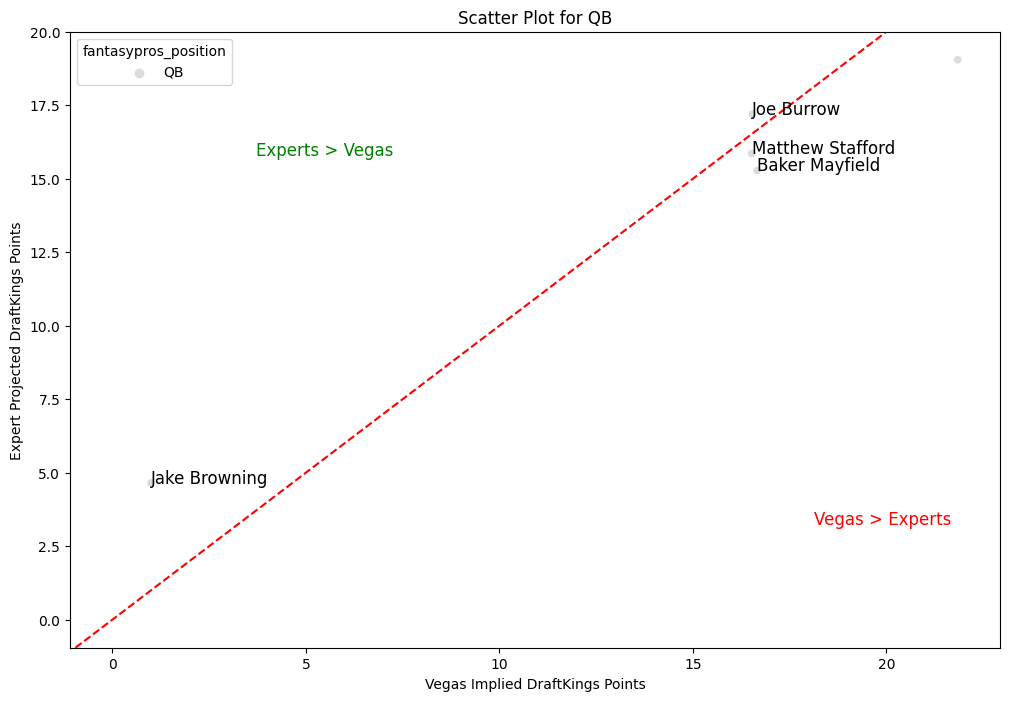

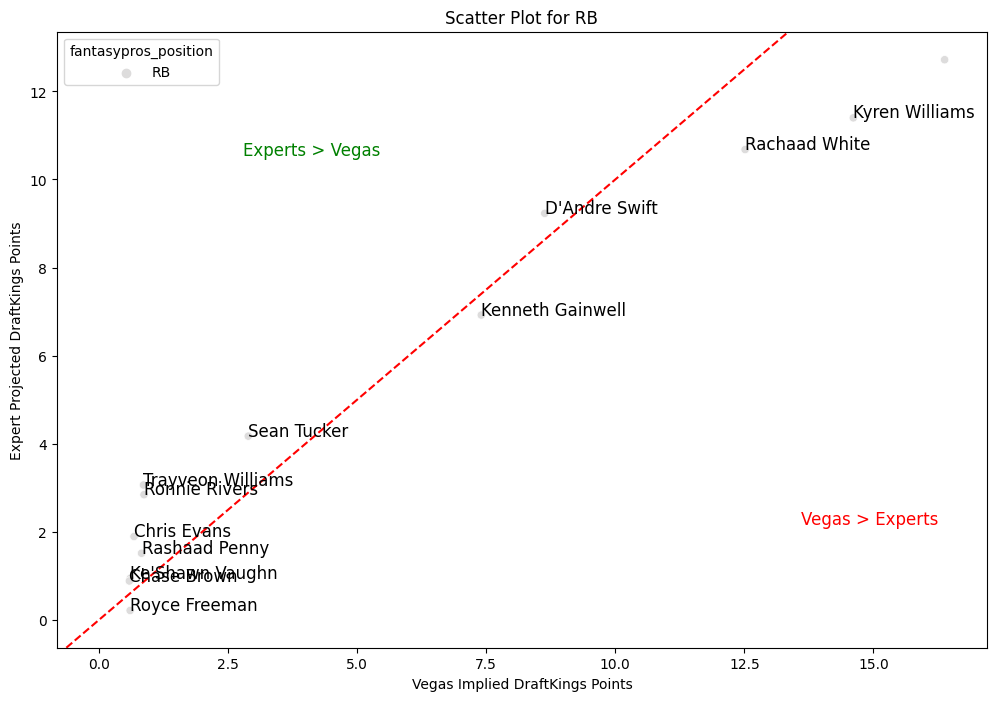

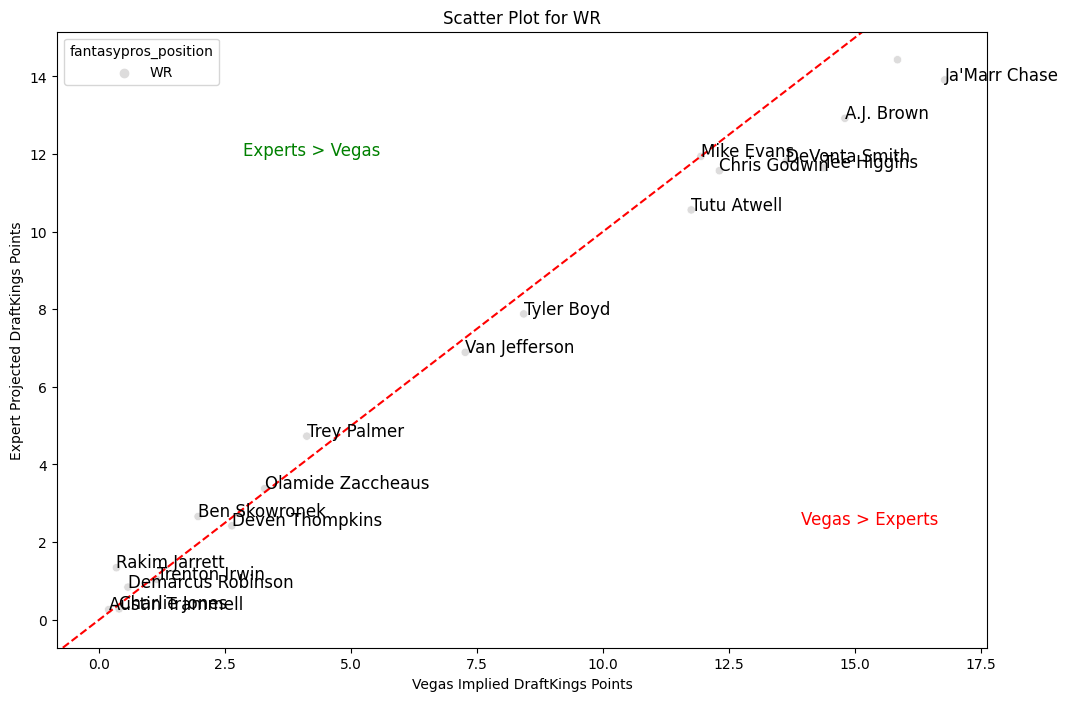

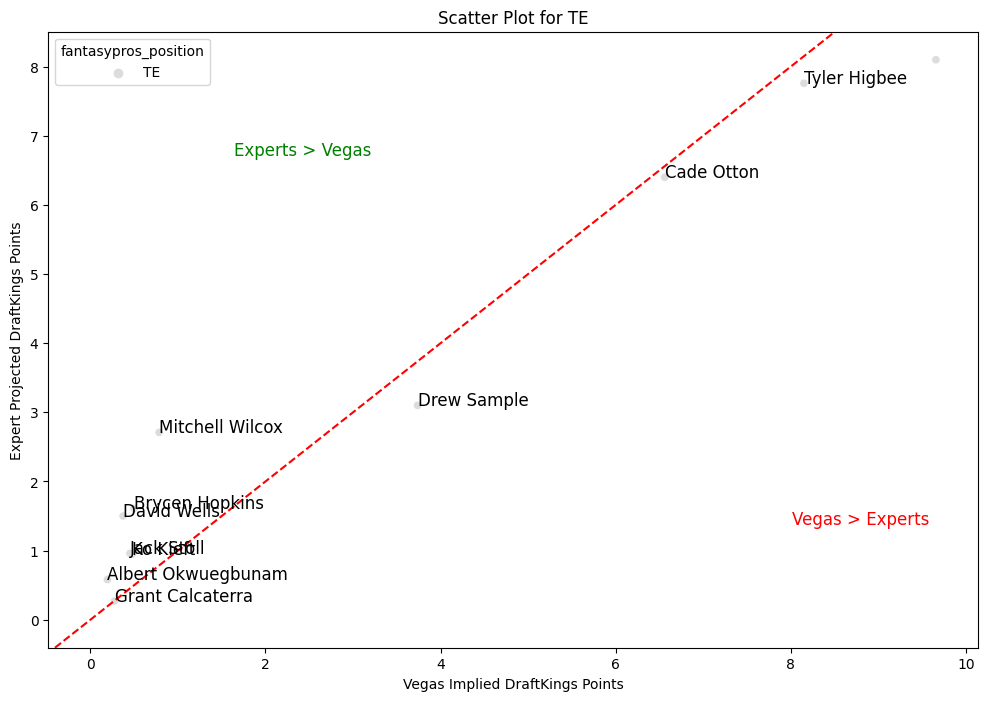

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the positional rank based on implied and projected points
for position in final_df['fantasypros_position'].unique():
    subset_df = final_df[final_df['fantasypros_position'] == position]
    final_df.loc[subset_df.index, 'implied_positional_rank'] = subset_df['implied_draftkings_fantasy_points'].rank(ascending=False)
    final_df.loc[subset_df.index, 'projected_positional_rank'] = subset_df['projected_draftkings_fantasy_points'].rank(ascending=False)

# Calculate the difference in ranks
final_df['rank_difference'] = final_df['implied_positional_rank'] - final_df['projected_positional_rank']

# Loop through each unique position to create scatter plots
for position in final_df['fantasypros_position'].unique():
    subset_df = final_df[final_df['fantasypros_position'] == position]

    # Identify players whose rank difference is more than 4 in either direction
    label_indices = subset_df[subset_df['rank_difference'].abs() > 6].index

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=subset_df, x='implied_draftkings_fantasy_points', y='projected_draftkings_fantasy_points', hue='fantasypros_position', palette='coolwarm')

    # Label the points
    for i in label_indices:
        plt.text(subset_df.loc[i, 'implied_draftkings_fantasy_points'], subset_df.loc[i, 'projected_draftkings_fantasy_points'], subset_df.loc[i, 'fantasypros_name'], fontsize=12)

    plt.title(f'Scatter Plot for {position}')
    plt.xlabel('Vegas Implied DraftKings Points')
    plt.ylabel('Expert Projected DraftKings Points')
    plt.axline([0, 0], [1, 1], color='red', linestyle='--')

    # Add annotations
    plt.annotate('Experts > Vegas', xy=(0.2, 0.8), xycoords='axes fraction', fontsize=12, color='green')
    plt.annotate('Vegas > Experts', xy=(0.8, 0.2), xycoords='axes fraction', fontsize=12, color='red')

    plt.show()


In [ ]:
import pandas as pd

# Calculate the difference between implied and career mean
final_df['difference'] = final_df['implied_draftkings_fantasy_points'] - final_df['projected_draftkings_fantasy_points']

# Sort by the difference and drop NaNs
sorted_df = final_df.dropna(subset=['fantasypros_name']).sort_values(by='difference', ascending=False)

# Function to apply styling
def highlight_diff(s):
    if s['difference'] > 0:
        return ['color: green' if v == s['difference'] else '' for v in s]
    elif s['difference'] < 0:
        return ['color: red' if v == s['difference'] else '' for v in s]
    else:
        return ['' for _ in s]

# Apply styling and display the top 10 positive and negative differences for each position
for position in sorted_df['fantasypros_position'].unique():
    position_df = sorted_df[sorted_df['fantasypros_position'] == position]
    top_10_positive = position_df.head(10)
    top_10_negative = position_df.tail(10)

    print(f"Top 10 Positive Differences for {position}")
    display(top_10_positive.style.apply(highlight_diff, axis=1))

    print(f"Top 10 Negative Differences for {position}")
    display(top_10_negative.style.apply(highlight_diff, axis=1))




Top 10 Positive Differences for RB


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
86,Joe Mixon,CIN,RB,12.720000,16.380602,joemixon,9/25/2023,1.000000,7.000000,-6.000000,3.660602
89,Kyren Williams,LA,RB,11.400000,14.611339,kyrenwilliams,9/25/2023,2.000000,10.000000,-8.000000,3.211339
112,Rachaad White,TB,RB,10.680000,12.514995,rachaadwhite,9/25/2023,3.000000,13.000000,-10.000000,1.834995
154,Kenneth Gainwell,PHI,RB,6.920000,7.403185,kennethgainwell,9/25/2023,5.000000,36.000000,-31.000000,0.483185
454,Royce Freeman,HOU,RB,0.210000,0.600000,roycefreeman,9/25/2023,12.000000,116.000000,-104.000000,0.390000
378,Chase Brown,CIN,RB,0.880000,0.584848,chasebrown,9/25/2023,13.000000,94.000000,-81.000000,-0.295152
349,Ke'Shawn Vaughn,TB,RB,0.940000,0.601774,keshawnvaughn,9/25/2023,11.000000,90.000000,-79.000000,-0.338226
124,D'Andre Swift,PHI,RB,9.230000,8.632573,dandreswift,9/25/2023,4.000000,27.000000,-23.000000,-0.597427
316,Rashaad Penny,PHI,RB,1.510000,0.820946,rashaadpenny,9/25/2023,9.000000,86.000000,-77.000000,-0.689054
317,Chris Evans,CIN,RB,1.890000,0.675446,chrisevans,9/25/2023,10.000000,76.500000,-66.500000,-1.214554


Top 10 Negative Differences for RB


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
508,Kevin Harris,nan,RB,0.000000,nan,kevinharris,nan,nan,130.000000,nan,nan
509,Derrick Gore,nan,RB,0.000000,nan,derrickgore,nan,nan,130.000000,nan,nan
516,Darrynton Evans,nan,RB,0.000000,nan,darryntonevans,nan,nan,130.000000,nan,nan
518,Javian Hawkins,nan,RB,0.000000,nan,javianhawkins,nan,nan,130.000000,nan,nan
525,Demetric Felton,nan,RB,0.000000,nan,demetricfelton,nan,nan,130.000000,nan,nan
528,Snoop Conner,nan,RB,0.000000,nan,snoopconner,nan,nan,130.000000,nan,nan
539,Gerrid Doaks,nan,RB,0.000000,nan,gerriddoaks,nan,nan,130.000000,nan,nan
551,Corey Clement,nan,RB,0.000000,nan,coreyclement,nan,nan,130.000000,nan,nan
553,Patrick Laird,nan,RB,0.000000,nan,patricklaird,nan,nan,130.000000,nan,nan
571,Jacques Patrick,nan,RB,0.000000,nan,jacquespatrick,nan,nan,130.000000,nan,nan


Top 10 Positive Differences for WR


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
104,Ja'Marr Chase,CIN,WR,13.910000,16.780309,jamarrchase,9/25/2023,1.000000,8.000000,-7.000000,2.870309
125,Tee Higgins,CIN,WR,11.650000,14.375450,teehiggins,9/25/2023,4.000000,19.000000,-15.000000,2.725450
110,A.J. Brown,PHI,WR,12.920000,14.800464,ajbrown,9/25/2023,3.000000,13.000000,-10.000000,1.880464
126,DeVonta Smith,PHI,WR,11.820000,13.639190,devontasmith,9/25/2023,5.000000,18.000000,-13.000000,1.819190
113,Puka Nacua,LA,WR,14.430000,15.844985,pukanacua,9/25/2023,2.000000,7.000000,-5.000000,1.414985
143,Tutu Atwell,LA,WR,10.560000,11.750529,tutuatwell,9/25/2023,8.000000,33.000000,-25.000000,1.190529
148,Chris Godwin,TB,WR,11.570000,12.309497,chrisgodwin,9/25/2023,6.000000,20.000000,-14.000000,0.739497
185,Tyler Boyd,CIN,WR,7.880000,8.426115,tylerboyd,9/25/2023,9.000000,48.500000,-39.500000,0.546115
191,Van Jefferson,LA,WR,6.890000,7.265850,vanjefferson,9/25/2023,10.000000,64.000000,-54.000000,0.375850
310,Deven Thompkins,TB,WR,2.420000,2.634575,deventhompkins,9/25/2023,13.000000,115.000000,-102.000000,0.214575


Top 10 Negative Differences for WR


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
559,Andy Isabella,nan,WR,0.000000,nan,andyisabella,nan,nan,199.500000,nan,nan
560,Seth Williams,nan,WR,0.000000,nan,sethwilliams,nan,nan,199.500000,nan,nan
562,Tyron Johnson,nan,WR,0.000000,nan,tyronjohnson,nan,nan,199.500000,nan,nan
564,Keelan Doss,nan,WR,0.000000,nan,keelandoss,nan,nan,199.500000,nan,nan
565,Tyler Johnson,nan,WR,0.000000,nan,tylerjohnson,nan,nan,199.500000,nan,nan
566,Joseph Ngata,nan,WR,0.000000,nan,josephngata,nan,nan,199.500000,nan,nan
567,Keelan Cole,nan,WR,0.000000,nan,keelancole,nan,nan,199.500000,nan,nan
568,Willie Snead,nan,WR,0.000000,nan,williesnead,nan,nan,199.500000,nan,nan
569,Racey McMath,nan,WR,0.000000,nan,raceymcmath,nan,nan,199.500000,nan,nan
570,Tanner Conner,nan,WR,0.000000,nan,tannerconner,nan,nan,199.500000,nan,nan


Top 10 Positive Differences for QB


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
1,Jalen Hurts,PHI,QB,19.050000,21.844965,jalenhurts,9/25/2023,1.000000,6.000000,-5.000000,2.794965
19,Baker Mayfield,TB,QB,15.282000,16.663301,bakermayfield,9/25/2023,2.000000,20.000000,-18.000000,1.381301
17,Matthew Stafford,LA,QB,15.856000,16.517931,matthewstafford,9/25/2023,4.000000,18.000000,-14.000000,0.661931
10,Joe Burrow,CIN,QB,17.200000,16.538054,joeburrow,9/25/2023,3.000000,12.000000,-9.000000,-0.661946
32,Jake Browning,CIN,QB,4.652000,1.000000,jakebrowning,9/25/2023,5.000000,33.000000,-28.000000,-3.652000
0,Patrick Mahomes,nan,QB,27.036000,nan,patrickmahomes,nan,nan,1.000000,nan,nan
2,Josh Allen,nan,QB,20.102000,nan,joshallen,nan,nan,3.000000,nan,nan
3,Lamar Jackson,nan,QB,19.828000,nan,lamarjackson,nan,nan,5.000000,nan,nan
4,Justin Herbert,nan,QB,19.982000,nan,justinherbert,nan,nan,4.000000,nan,nan
5,Kirk Cousins,nan,QB,20.150000,nan,kirkcousins,nan,nan,2.000000,nan,nan


Top 10 Negative Differences for QB


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
70,Matt Barkley,nan,QB,0.000000,nan,mattbarkley,nan,nan,72.500000,nan,nan
71,Logan Woodside,nan,QB,0.000000,nan,loganwoodside,nan,nan,72.500000,nan,nan
72,Shane Buechele,nan,QB,0.000000,nan,shanebuechele,nan,nan,72.500000,nan,nan
73,Ben DiNucci,nan,QB,0.000000,nan,bendinucci,nan,nan,72.500000,nan,nan
74,Malik Cunningham,nan,QB,0.000000,nan,malikcunningham,nan,nan,72.500000,nan,nan
75,David Blough,nan,QB,0.000000,nan,davidblough,nan,nan,72.500000,nan,nan
76,Nathan Peterman,nan,QB,0.000000,nan,nathanpeterman,nan,nan,72.500000,nan,nan
77,Josh Johnson,nan,QB,0.000000,nan,joshjohnson,nan,nan,72.500000,nan,nan
78,Reid Sinnett,nan,QB,0.000000,nan,reidsinnett,nan,nan,72.500000,nan,nan
547,Feleipe Franks,nan,QB,0.000000,nan,feleipefranks,nan,nan,72.500000,nan,nan


Top 10 Positive Differences for TE


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
179,Dallas Goedert,PHI,TE,8.100000,9.658340,dallasgoedert,9/25/2023,1.000000,7.000000,-6.000000,1.558340
302,Drew Sample,CIN,TE,3.100000,3.737606,drewsample,9/25/2023,4.000000,39.000000,-35.000000,0.637606
197,Tyler Higbee,LA,TE,7.760000,8.150770,tylerhigbee,9/25/2023,2.000000,9.000000,-7.000000,0.390770
224,Cade Otton,TB,TE,6.400000,6.560579,cadeotton,9/25/2023,3.000000,20.000000,-17.000000,0.160579
442,Grant Calcaterra,PHI,TE,0.270000,0.275050,grantcalcaterra,9/25/2023,10.000000,103.000000,-93.000000,0.005050
402,Albert Okwuegbunam,DEN,TE,0.580000,0.193548,albertokwuegbunam,9/25/2023,11.000000,89.000000,-78.000000,-0.386452
385,Ko Kieft,TB,TE,0.950000,0.478586,kokieft,9/25/2023,7.000000,74.000000,-67.000000,-0.471414
392,Jack Stoll,PHI,TE,0.960000,0.451447,jackstoll,9/25/2023,8.000000,73.000000,-65.000000,-0.508553
346,Brycen Hopkins,LA,TE,1.610000,0.498599,brycenhopkins,9/25/2023,6.000000,56.000000,-50.000000,-1.111401
363,David Wells,TB,TE,1.500000,0.372888,davidwells,9/25/2023,9.000000,59.000000,-50.000000,-1.127112


Top 10 Negative Differences for TE


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
534,Tommy Hudson,nan,TE,0.000000,nan,tommyhudson,nan,nan,121.500000,nan,nan
536,Stephen Sullivan,nan,TE,0.000000,nan,stephensullivan,nan,nan,121.500000,nan,nan
537,Lucas Krull,nan,TE,0.000000,nan,lucaskrull,nan,nan,121.500000,nan,nan
542,Matt Sokol,nan,TE,0.000000,nan,mattsokol,nan,nan,121.500000,nan,nan
543,Darrell Daniels,nan,TE,0.000000,nan,darrelldaniels,nan,nan,121.500000,nan,nan
549,Hunter Kampmoyer,nan,TE,0.000000,nan,hunterkampmoyer,nan,nan,121.500000,nan,nan
557,Nick Vannett,nan,TE,0.000000,nan,nickvannett,nan,nan,121.500000,nan,nan
558,Tyree Jackson,nan,TE,0.000000,nan,tyreejackson,nan,nan,121.500000,nan,nan
561,Nick Bowers,nan,TE,0.000000,nan,nickbowers,nan,nan,121.500000,nan,nan
563,Kevin Rader,nan,TE,0.000000,nan,kevinrader,nan,nan,121.500000,nan,nan


In [ ]:
# Fill 'implied_draftkings_fantasy_points' with 'projected_draftkings_fantasy_points' where 'player_display_name' is null
final_df.loc[final_df['most_recent_team'].isna(), 'implied_draftkings_fantasy_points'] = final_df['projected_draftkings_fantasy_points']


In [ ]:
final_df

,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
0,Patrick Mahomes,NaN,QB,27.036,27.036000,patrickmahomes,NaN,NaN,1.0,NaN,NaN
1,Jalen Hurts,PHI,QB,19.050,21.844965,jalenhurts,9/25/2023,1.0,6.0,-5.0,2.794965
2,Josh Allen,NaN,QB,20.102,20.102000,joshallen,NaN,NaN,3.0,NaN,NaN
3,Lamar Jackson,NaN,QB,19.828,19.828000,lamarjackson,NaN,NaN,5.0,NaN,NaN
4,Justin Herbert,NaN,QB,19.982,19.982000,justinherbert,NaN,NaN,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
567,Keelan Cole,NaN,WR,0.000,0.000000,keelancole,NaN,NaN,199.5,NaN,NaN
568,Willie Snead,NaN,WR,0.000,0.000000,williesnead,NaN,NaN,199.5,NaN,NaN
569,Racey McMath,NaN,WR,0.000,0.000000,raceymcmath,NaN,NaN,199.5,NaN,NaN
570,Tanner Conner,NaN,WR,0.000,0.000000,tannerconner,NaN,NaN,199.5,NaN,NaN


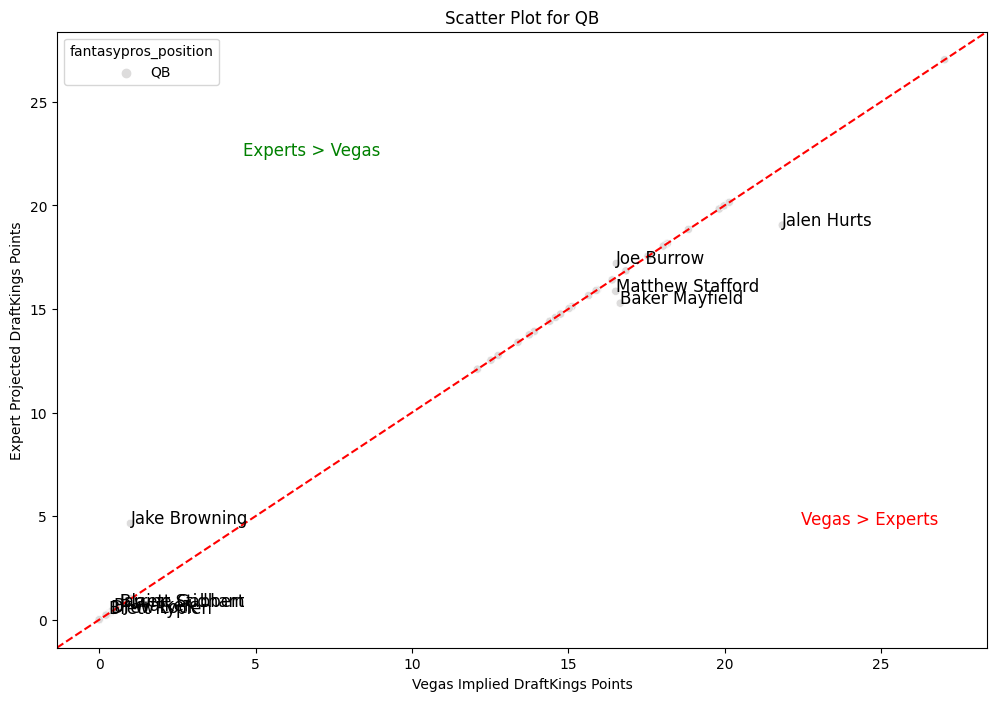

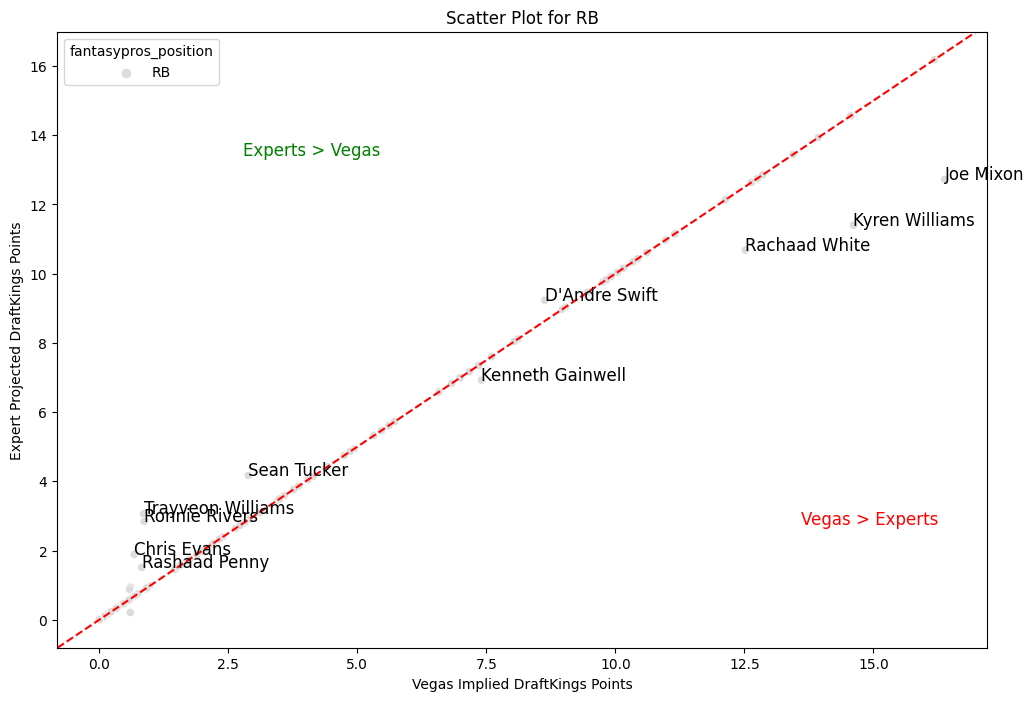

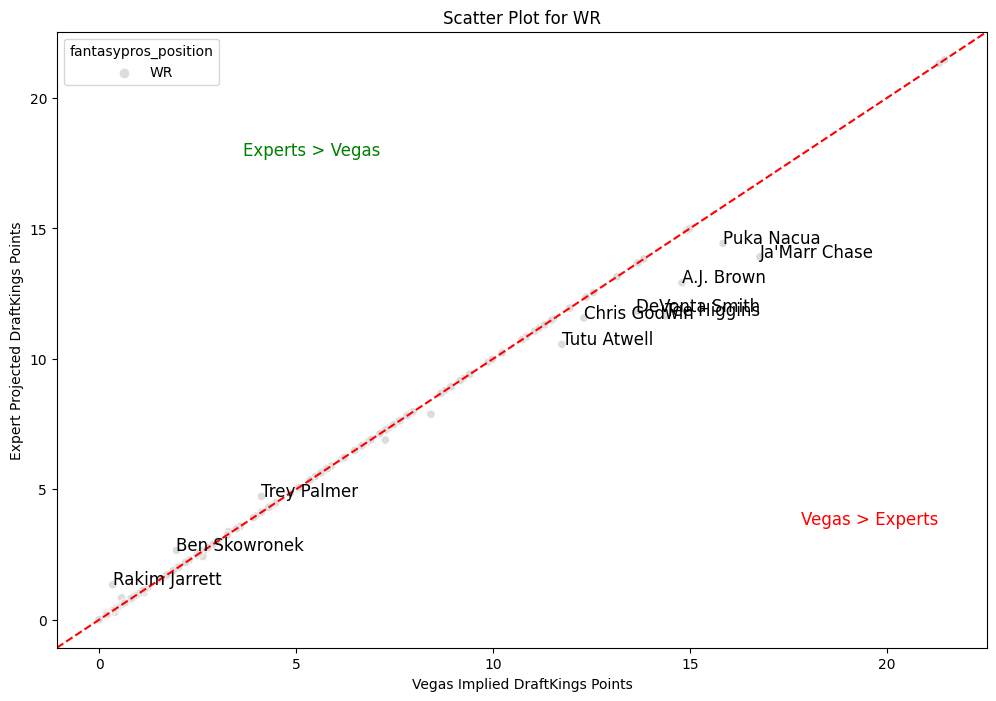

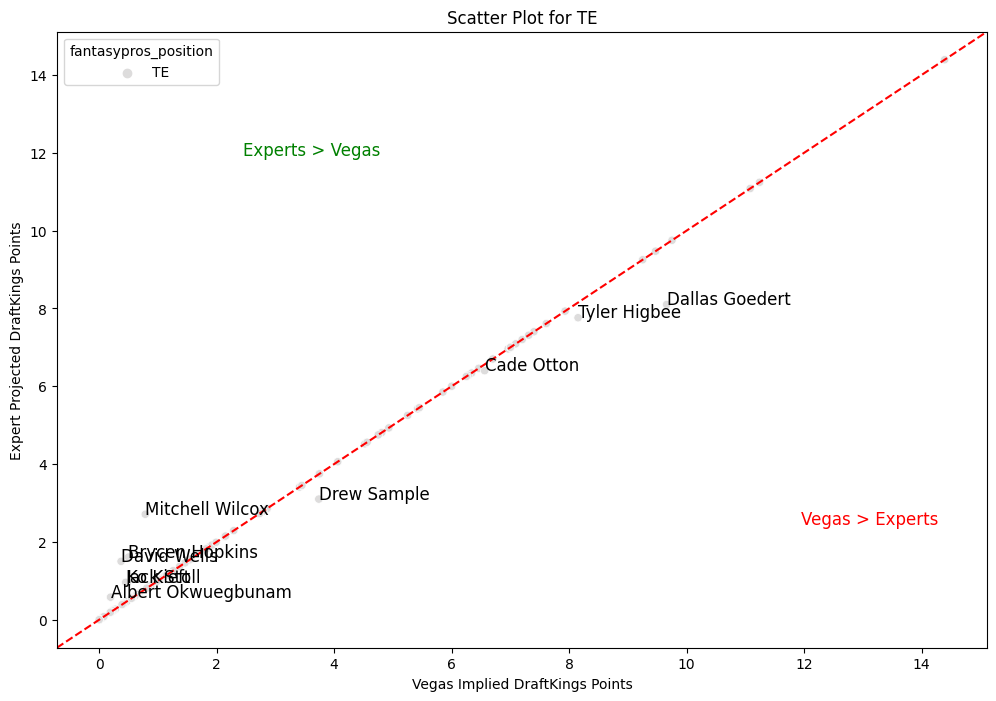

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the difference between expert and implied points
final_df['difference'] = final_df['projected_draftkings_fantasy_points'] - final_df['implied_draftkings_fantasy_points']

# Loop through each unique position
for position in final_df['fantasypros_position'].unique():
    subset_df = final_df[final_df['fantasypros_position'] == position]

    # Sort by absolute difference and get top 10
    top_10_diff = subset_df['difference'].abs().sort_values(ascending=False).head(10).index

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=subset_df, x='implied_draftkings_fantasy_points', y='projected_draftkings_fantasy_points', hue='fantasypros_position', palette='coolwarm')

    # Label the points
    for i in top_10_diff:
        plt.text(subset_df.loc[i, 'implied_draftkings_fantasy_points'], subset_df.loc[i, 'projected_draftkings_fantasy_points'], subset_df.loc[i, 'fantasypros_name'], fontsize=12)

    plt.title(f'Scatter Plot for {position}')
    plt.xlabel('Vegas Implied DraftKings Points')
    plt.ylabel('Expert Projected DraftKings Points')
    plt.axline([0, 0], [1, 1], color='red', linestyle='--')

    # Add annotations
    plt.annotate('Experts > Vegas', xy=(0.2, 0.8), xycoords='axes fraction', fontsize=12, color='green')
    plt.annotate('Vegas > Experts', xy=(0.8, 0.2), xycoords='axes fraction', fontsize=12, color='red')

    plt.show()


In [ ]:
# Sort the DataFrame by 'fantasypros_position' and 'difference'
final_df.sort_values(by=['fantasypros_position', 'difference'], inplace=True)

# Loop through each unique position to find the top 10 players with the highest negative difference
for position in final_df['fantasypros_position'].unique():
    subset_df = final_df[final_df['fantasypros_position'] == position]

    # Filter out the top 10 players with the highest negative difference and a minimum difference of 5 points
    top_10_negative_diff = subset_df[subset_df['difference'] >= -5].head(10)

    # Display the top 10 players with the highest negative difference for the current position
    if not top_10_negative_diff.empty:
        print(f"Top 10 Players with the Highest Negative Difference (Vegas > Experts) for {position}:")
        display(top_10_negative_diff[['fantasypros_name', 'implied_draftkings_fantasy_points', 'projected_draftkings_fantasy_points', 'difference']])
    else:
        print(f"No players with a minimum difference of 5 points for {position}.")


Top 10 Players with the Highest Negative Difference (Vegas > Experts) for QB:


,fantasypros_name,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
1,Jalen Hurts,21.844965,19.050,-2.794965
19,Baker Mayfield,16.663301,15.282,-1.381301
17,Matthew Stafford,16.517931,15.856,-0.661931
0,Patrick Mahomes,27.036000,27.036,0.000000
2,Josh Allen,20.102000,20.102,0.000000
3,Lamar Jackson,19.828000,19.828,0.000000
4,Justin Herbert,19.982000,19.982,0.000000
5,Kirk Cousins,20.150000,20.150,0.000000
6,Tua Tagovailoa,18.844000,18.844,0.000000
7,Trevor Lawrence,18.168000,18.168,0.000000


Top 10 Players with the Highest Negative Difference (Vegas > Experts) for RB:


,fantasypros_name,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
86,Joe Mixon,16.380602,12.72,-3.660602
89,Kyren Williams,14.611339,11.40,-3.211339
112,Rachaad White,12.514995,10.68,-1.834995
154,Kenneth Gainwell,7.403185,6.92,-0.483185
454,Royce Freeman,0.600000,0.21,-0.390000
79,Christian McCaffrey,16.180000,16.18,0.000000
80,Tony Pollard,14.560000,14.56,0.000000
83,Derrick Henry,12.750000,12.75,0.000000
84,Bijan Robinson,13.930000,13.93,0.000000
85,Josh Jacobs,12.630000,12.63,0.000000


Top 10 Players with the Highest Negative Difference (Vegas > Experts) for TE:


,fantasypros_name,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
179,Dallas Goedert,9.658340,8.10,-1.558340
302,Drew Sample,3.737606,3.10,-0.637606
197,Tyler Higbee,8.150770,7.76,-0.390770
224,Cade Otton,6.560579,6.40,-0.160579
442,Grant Calcaterra,0.275050,0.27,-0.005050
94,Travis Kelce,14.390000,14.39,0.000000
129,Mark Andrews,11.240000,11.24,0.000000
136,T.J. Hockenson,11.080000,11.08,0.000000
145,George Kittle,9.470000,9.47,0.000000
161,Darren Waller,9.750000,9.75,0.000000


Top 10 Players with the Highest Negative Difference (Vegas > Experts) for WR:


,fantasypros_name,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
104,Ja'Marr Chase,16.780309,13.91,-2.870309
125,Tee Higgins,14.375450,11.65,-2.725450
110,A.J. Brown,14.800464,12.92,-1.880464
126,DeVonta Smith,13.639190,11.82,-1.819190
113,Puka Nacua,15.844985,14.43,-1.414985
143,Tutu Atwell,11.750529,10.56,-1.190529
148,Chris Godwin,12.309497,11.57,-0.739497
185,Tyler Boyd,8.426115,7.88,-0.546115
191,Van Jefferson,7.265850,6.89,-0.375850
310,Deven Thompkins,2.634575,2.42,-0.214575


In [ ]:
# Filter players with a projected total of at least 5 points
filtered_df = final_df[final_df['projected_draftkings_fantasy_points'] >= 5]

# Sort the DataFrame by 'difference'
filtered_df.sort_values(by='difference', inplace=True)

# Get the top 10 players with the highest negative difference (Vegas > Experts)
top_10_negative_diff = filtered_df.head(10)

# Display the top 10 players with the highest negative difference
if not top_10_negative_diff.empty:
    print("Top 10 Players with the Highest Negative Difference (Vegas > Experts) Across All Positions:")
    display(top_10_negative_diff[['fantasypros_name', 'fantasypros_position', 'implied_draftkings_fantasy_points', 'projected_draftkings_fantasy_points', 'difference']])
else:
    print("No players meet the criteria.")


Top 10 Players with the Highest Negative Difference (Vegas > Experts) Across All Positions:


<ipython-input-1616-7f661e49be5a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.sort_values(by='difference', inplace=True)


,fantasypros_name,fantasypros_position,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
86,Joe Mixon,RB,16.380602,12.72,-3.660602
89,Kyren Williams,RB,14.611339,11.40,-3.211339
104,Ja'Marr Chase,WR,16.780309,13.91,-2.870309
1,Jalen Hurts,QB,21.844965,19.05,-2.794965
125,Tee Higgins,WR,14.375450,11.65,-2.725450
110,A.J. Brown,WR,14.800464,12.92,-1.880464
112,Rachaad White,RB,12.514995,10.68,-1.834995
126,DeVonta Smith,WR,13.639190,11.82,-1.819190
179,Dallas Goedert,TE,9.658340,8.10,-1.558340
113,Puka Nacua,WR,15.844985,14.43,-1.414985


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
final_df.columns

Index(['fantasypros_name', 'most_recent_team', 'fantasypros_position',
       'projected_draftkings_fantasy_points',
       'implied_draftkings_fantasy_points', 'merge_name', 'commence_time',
       'implied_positional_rank', 'projected_positional_rank',
       'rank_difference', 'difference'],
      dtype='object')

In [ ]:
# Drop rows where 'most_recent_team' is NaN
final_df.dropna(subset=['most_recent_team'], inplace=True)

In [ ]:
selected_columns

,player_display_name,merge_name,position,season,week,draftkings_fantasy_points
3,Jimmy Graham,jimmygraham,TE,2023,3,7.80
4,Blaine Gabbert,blainegabbert,QB,2023,3,-0.86
5,Andy Dalton,andydalton,QB,2023,3,26.54
8,Randall Cobb,randallcobb,WR,2023,3,2.20
10,Tyrod Taylor,tyrodtaylor,QB,2023,3,0.20
...,...,...,...,...,...,...
888,Jahmyr Gibbs,jahmyrgibbs,RB,2023,3,9.20
891,Luke Musgrave,lukemusgrave,TE,2023,3,10.90
894,Jayden Reed,jaydenreed,WR,2023,3,9.30
899,C.J. Stroud,cjstroud,QB,2023,3,20.60


In [ ]:
# Save the DataFrame to a CSV file
final_df.to_csv('final_df.csv', index=False)


In [ ]:
# Assuming 'df' contains your selected data, and 'final_df' is your main DataFrame
final_df = final_df[(final_df['implied_draftkings_fantasy_points'] > 2)]

# Step 1: Merge the data
validation_df = final_df.merge(selected_columns, left_on=['merge_name'], right_on=['merge_name'], how='left')

# Step 2: Calculate the error in terms of fantasy points
validation_df['projection_error'] = validation_df['draftkings_fantasy_points'] - validation_df['projected_draftkings_fantasy_points']
validation_df['implied_error'] = validation_df['draftkings_fantasy_points'] - validation_df['implied_draftkings_fantasy_points']


# Step 3: Rank players by actual fantasy points
validation_df['actual_rank'] = validation_df.groupby('fantasypros_position')['draftkings_fantasy_points'].rank(ascending=False, method='dense')

# Step 4: Calculate rank differences for implied and projected points
validation_df['implied_rank'] = validation_df.groupby('fantasypros_position')['implied_draftkings_fantasy_points'].rank(ascending=False, method='dense')
validation_df['projected_rank'] = validation_df.groupby('fantasypros_position')['projected_draftkings_fantasy_points'].rank(ascending=False, method='dense')
validation_df['rank_difference_implied'] = validation_df['actual_rank'] - validation_df['implied_rank']
validation_df['rank_difference_projected'] = validation_df['actual_rank'] - validation_df['projected_rank']

# Step 5: Filter relevant players based on your criteria
relevant_players = {
    'QB': 20,    # Top 12 QBs
    'RB': 40,    # Top 24 RBs
    'WR': 60,    # Top 36 WRs
    'TE': 20     # Top 12 TEs
}

# Filter based on positions and relevant player counts
for position, count in relevant_players.items():
    filtered_data = validation_df[validation_df['fantasypros_position'] == position].sort_values(by='actual_rank')
    relevant_data = filtered_data.head(count)

    # Now you can analyze relevant_data as needed

# Calculate average error
average_error = validation_df['projection_error'].mean()
print("ECR Average Error:", average_error)

average_error = validation_df['implied_error'].mean()
print("Implied Average Error:", average_error)


# You can also visualize the data and rank differences as per your requirements.


ECR Average Error: nan
Implied Average Error: nan


In [ ]:
validation_df.isnull().sum()

fantasypros_name                        0
most_recent_team                        0
fantasypros_position                    0
projected_draftkings_fantasy_points     0
implied_draftkings_fantasy_points       0
merge_name                              0
commence_time                           0
implied_positional_rank                 0
projected_positional_rank               0
rank_difference                         0
difference                              0
player_display_name                    27
position                               27
season                                 27
week                                   27
draftkings_fantasy_points              27
projection_error                       27
implied_error                          27
actual_rank                            27
implied_rank                            0
projected_rank                          0
rank_difference_implied                27
rank_difference_projected              27
dtype: int64

In [ ]:
# Assuming 'df' contains your selected data, and 'final_df' is your main DataFrame
final_df = final_df[(final_df['projected_draftkings_fantasy_points'] > 2)]

In [ ]:
import numpy as np

def calculate_metrics(data):
    actual = data['draftkings_fantasy_points']
    projected = data['projected_draftkings_fantasy_points']
    implied = data['implied_draftkings_fantasy_points']


    # Set a floor value for actual fantasy points
    floor_value = 1.0  # You can adjust this as needed

    # Calculate relative error and percent error for both projections
    epsilon = 1e-6  # Small positive value to avoid division by zero
    relative_error_projected = np.abs(actual - projected) / (actual + epsilon)
    relative_error_projected = np.where(actual < floor_value, 0, relative_error_projected)  # Set relative error to 0 when actual < floor_value
    percent_error_projected = (np.abs(actual - projected) / (actual + epsilon)) * 100
    percent_error_projected = np.where(actual < floor_value, 0, percent_error_projected)  # Set percent error to 0 when actual < floor_value

    relative_error_implied = np.abs(actual - implied) / (actual + epsilon)
    relative_error_implied = np.where(actual < floor_value, 0, relative_error_implied)  # Set relative error to 0 when actual < floor_value
    percent_error_implied = (np.abs(actual - implied) / (actual + epsilon)) * 100
    percent_error_implied = np.where(actual < floor_value, 0, percent_error_implied)  # Set percent error to 0 when actual < floor_value

    # Calculate RMSE and MAE for both projections
    rmse_projected = np.sqrt(np.mean((actual - projected) ** 2))
    mae_projected = np.mean(np.abs(actual - projected))

    rmse_implied = np.sqrt(np.mean((actual - implied) ** 2))
    mae_implied = np.mean(np.abs(actual - implied))

    return {
        'Projected RMSE': rmse_projected,
        'Projected MAE': mae_projected,
        'Projected Relative Error': relative_error_projected.mean(),
        'Projected Percent Error': percent_error_projected.mean(),
        'Implied RMSE': rmse_implied,
        'Implied MAE': mae_implied,
        'Implied Relative Error': relative_error_implied.mean(),
        'Implied Percent Error': percent_error_implied.mean()
    }


results_by_position = {}

# Iterate over positions and calculate metrics for each
positions = validation_df['fantasypros_position'].unique()
for position in positions:
    position_data = validation_df[validation_df['fantasypros_position'] == position]
    # Apply a threshold of 5 to exclude low projection values for this position's data
    mask = position_data['projected_draftkings_fantasy_points'] >= 5
    actual = position_data['draftkings_fantasy_points'][mask]
    projected = position_data['projected_draftkings_fantasy_points'][mask]
    implied = position_data['implied_draftkings_fantasy_points'][mask]

    results = calculate_metrics(position_data)
    results_by_position[position] = results




# Print or store the results for analysis
for position, results in results_by_position.items():
    sample_size = len(validation_df[validation_df['fantasypros_position'] == position])  # Get the size of the positional sample

    print(f"Position: {position} (Sample Size: {sample_size})")
    print(f"Projected RMSE: {results['Projected RMSE']:.2f}")
    print(f"Implied RMSE: {results['Implied RMSE']:.2f}")
    print()
    print(f"Projected MAE: {results['Projected MAE']:.2f}")
    print(f"Implied MAE: {results['Implied MAE']:.2f}")
    print()


Position: QB (Sample Size: 4)
Projected RMSE: nan
Implied RMSE: nan

Projected MAE: nan
Implied MAE: nan

Position: RB (Sample Size: 6)
Projected RMSE: nan
Implied RMSE: nan

Projected MAE: nan
Implied MAE: nan

Position: TE (Sample Size: 4)
Projected RMSE: nan
Implied RMSE: nan

Projected MAE: nan
Implied MAE: nan

Position: WR (Sample Size: 13)
Projected RMSE: nan
Implied RMSE: nan

Projected MAE: nan
Implied MAE: nan



In [ ]:
!pip install unicode

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 17 18:46:36 2023

@author: robertmegnia
"""

import pandas as pd
import os
import requests
import unidecode
from os.path import exists

basedir = os.path.dirname(os.path.abspath(__file__))
datadir = f"{basedir}/../../data"
salary_database = f"{basedir}/../../../../DraftKingsSalaryMegaDatabase2/NFL"
SALARY_URL = "https://www.draftkings.com/lineup"



def downloadDKSalaries(game_date, game_dates, contest, week, season):
    """

    Downloads  Draft Kings Salaries for given game date and contest type

    Parameters
    ----------
    game_date : str
        date string of format %Y-%m-%d
    contest : str
        Draft Kings contest type "Classic" or "Showdown"

    Returns
    -------
    df : pandas.DataFrame
         Draft Kings exported salary csv

    """
    url = "https://www.draftkings.com/lobby/getcontests?sport=NFL"
    response = requests.get(url).json()
    DraftGroups = pd.DataFrame(response["DraftGroups"])
    # Filter contest types to classic  and showdown using IDs 125,127 for hockey
    DraftGroups = DraftGroups[DraftGroups.ContestTypeId.isin([21, 96])]
    DraftGroups["StartDate"] = pd.to_datetime(
        DraftGroups.StartDateEst
    ).dt.tz_localize("US/Eastern")

    # Create column for slate starting time
    DraftGroups["Slate"] = DraftGroups.StartDate.apply(
        lambda x: x.strftime("%Y-%m-%d_%I:%M%p")
    )

    # Take first 10 characters of Slate to get %Y-%m-%d format game day
    DraftGroups["GameDay"] = DraftGroups.Slate.apply(lambda x: x[0:10])

    # Filter retrieved draftgroups to day in question
    DraftGroups = DraftGroups[DraftGroups.GameDay.isin(game_dates)]
    daily_sal_frames = []
    daily_sal_frames_SD = []
    classic = None
    showdown = None
    # Download all slates for game_date
    for group, slate, suffix in zip(
        DraftGroups.DraftGroupId,
        DraftGroups.Slate,
        DraftGroups.ContestStartTimeSuffix,
    ):
        url = f"{SALARY_URL}/getavailableplayerscsv?contestTypeId=28&draftGroupId={group}"
        df = pd.read_csv(url)
        if len(df)==0:
            continue

        if "CPT" in df["Roster Position"].unique():
            showdown = True
            team1, team2 = df.TeamAbbrev.unique()
            daily_sal_frames_SD.append(df)
            # Try to export, if directory doesn't exist, create it.
            try:
                if not exists(
                    f"{salary_database}/Showdown/{game_date}/{slate}_{team1}_{team2}_salaries.csv"
                ):
                    df.to_csv(
                        f"{salary_database}/Showdown/{game_date}/{slate}_{team1}_{team2}_salaries.csv",
                        index=False,
                    )
            except OSError:
                os.mkdir(f"{salary_database}//Showdown/{game_date}/")
                if not exists(
                    f"{salary_database}/Showdown/{game_date}/{slate}_{team1}_{team2}_salaries.csv"
                ):
                    df.to_csv(
                        f"{salary_database}/Showdown/{game_date}/{slate}_{team1}_{team2}_salaries.csv",
                        index=False,
                    )
        else:
            # Try to export, if directory doesn't exist, create it.
            classic = True
            daily_sal_frames.append(df)
            if suffix is None:
                suffix = ""
            elif "-" in suffix:
                suffix = suffix.replace("-", "_")
                suffix = suffix.replace("(", "")
                suffix = suffix.replace(")", "")
                suffix = suffix.replace(" ", "")
                suffix = f"_{suffix}"
            elif "Only" in suffix:
                suffix = suffix.replace(" ", "_")
                suffix = suffix.replace("(", "")
                suffix = suffix.replace(")", "")
                suffix = f"{suffix}"
            try:
                if not exists(
                    f"{salary_database}/Classic/{game_date}/{slate}_salaries{suffix}.csv"
                ):
                    df.to_csv(
                        f"{salary_database}/Classic/{game_date}/{slate}_salaries{suffix}.csv",
                        index=False,
                    )
            except OSError:
                os.mkdir(f"{salary_database}/Classic/{game_date}/")
                if not exists(
                    f"{salary_database}/Classic/{game_date}/{slate}_salaries{suffix}.csv"
                ):
                    df.to_csv(
                        f"{salary_database}/Classic/{game_date}/{slate}_salaries{suffix}.csv",
                        index=False,
                    )
    if classic == True:
        daily_sal = pd.concat(daily_sal_frames)
        daily_sal = daily_sal.groupby(
            ["full_name", "team", "Roster Position", "position"], as_index=False
        ).first()
        if not exists(f"{salary_database}/Classic/{game_date}/{game_date}_salaries.csv"):
            try:
                daily_sal['week']=week
                daily_sal['season']=season
                daily_sal.to_csv(
                    f"{salary_database}/Classic/{game_date}/{game_date}_salaries.csv",
                    index=False,
                )
            except OSError:
                os.mkdir(f"{salary_database}/Classic/{game_date}/")
                daily_sal['week']=week
                daily_sal['season']=season
                daily_sal.to_csv(
                    f"{salary_database}/Classic/{game_date}/{game_date}_salaries.csv",
                    index=False,
                )
    if showdown == True:
        daily_sal_SD = pd.concat(daily_sal_frames_SD)
        if not exists(f"{salary_database}/Showdown/{game_date}/{game_date}_salaries.csv"):
            try:
                daily_sal_SD.to_csv(
                    f"{salary_database}/Showdown/{game_date}/{game_date}_salaries.csv",
                    index=False,
                )
            except OSError:
                os.mkdir(f"{salary_database}/Showdown/{game_date}/")
                daily_sal_SD.to_csv(
                    f"{salary_database}/Showdown/{game_date}/{game_date}_salaries.csv",
                    index=False,
                )
    if contest == "Classic":
        daily_sal = pd.read_csv(f"{salary_database}/Classic/{game_date}/{game_date}_salaries.csv")
        return daily_sal
    else:
        return daily_sal_SD


def getDKSalaries(game_date, game_dates, week, season, contest="Classic"):
    """


    Parameters
    ----------
    game_date : str
        date string of format %Y-%m-%d
    contest : str
        Draft Kings contest type "Classic" or "Showdown"

    Returns
    -------
    salaries : pandas.DataFrame
    slate: str

    """

    salaries = downloadDKSalaries(game_date, game_dates, contest, week, season)
    if os.path.exists(f'{datadir}/DKSalaries/{season}_salaries.csv'):
        db = pd.read_csv(f'{datadir}/DKSalaries/{season}_salaries.csv')
        db=db[db.week!=week]
        db=pd.concat([salaries,db])
        db.to_csv(f'{datadir}/DKSalaries/{season}_salaries.csv',index=False)
    else:
        salaries.to_csv(f'{datadir}/DKSalaries/{season}_salaries.csv',index=False)
    salaries.loc[salaries.position == "DST", "full_name"] = salaries.loc[
        salaries.position == "DST", "team"
    ]
    salaries.loc[salaries.position == "DST", "RotoName"] = salaries.loc[
        salaries.position == "DST", "team"
    ]
    return salaries

ModuleNotFoundError: ignored